# Implémentez un modèle de scoring


Etude data - Projet 7 - fevrier 2023

*Data source* : [Jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.\
**On s'interresera surtout au recall car on voudrait pas accorder un credit à un client qui ne sera pas capable de rembourser**: La sensibilité (recall) mesure la capacité du modèle à détecter les clients réellement négatifs, c'est-à-dire ceux qui présentent un risque de défaut de crédit. Une sensibilité élevée est généralement souhaitable dans le contexte du scoring de crédit, car cela signifie que le modèle identifie efficacement les clients présentant un risque élevé.

In [2]:
import sys
#print(sys.executable)

In [18]:
pip show requests-mock

Name: requests-mock
Version: 1.11.0
Summary: Mock out responses from the requests package
Home-page: https://requests-mock.readthedocs.io/
Author: Jamie Lennox
Author-email: jamielennox@gmail.com
License: Apache-2
Location: c:\users\aella\anaconda3\envs\monenvprojet\lib\site-packages
Requires: requests, six
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!{sys.executable} -m pip install pygwalker -q

In [4]:
!python --version

Python 3.9.16


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from zipfile import ZipFile

import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, roc_curve 

from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate, KFold, StratifiedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import fbeta_score, confusion_matrix

from sklearn.feature_selection import RFECV

from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
# import matplotlib
# print(matplotlib.__version__)

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':11,
     'ytick.labelsize':11,
     'axes.labelsize': 11,
     'legend.fontsize': 11,
     'axes.titlesize':11,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## 1. Chargement des data sets:

Une étude de corrélation a été effectuée sur le notebook exploration et on avait constaté qu'il y avait des variables fortement correlées.
On utilise ici le data sets que l'on a rétiré la corrélation des variables explicatives.

In [296]:
def load_data(path):
    data = pd.read_csv(path)
    return data

In [297]:
path_new_data = "C:/Users/aella/Desktop/apprentissage_data_science/Openclassrooms/projet7/projet7_github_Abdoullatuf_Maoulida/notebooks_P7/Data_projet7/new_data/"

In [298]:
# Charger les données
df = load_data(path_new_data + 'df_train_without_corr.csv')
df_dashboard =  load_data(path_new_data + 'df_test_without_corr.csv')
print("Shape du DataFrame :", df.shape)
print("Shape du DataFrame pour le dashbord :", df_dashboard.shape)

Shape du DataFrame : (72793, 483)
Shape du DataFrame pour le dashbord : (14464, 482)


In [299]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(df.head(5))

Aperçu des premières lignes du DataFrame :
   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100011       0            1             0                0   
1      100023       0            1             0                0   
2      100036       0            1             0                0   
3      100043       0            1             0                0   
4      100047       1            0             0                0   

   AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0          112500.0   1019610.0                    0.018634      -20099   
1           90000.0    544491.0                    0.015221      -11348   
2          112500.0    512064.0                    0.008575      -11144   
3          198000.0    641173.5                    0.018850      -17199   
4          202500.0   1193580.0                    0.025164      -17482   

   DAYS_REGISTRATION  ...  CC_NAME_CONTRACT_STATUS_Sent proposal_SUM  \
0            -7427.

In [300]:
# df_test = load_data(path_new_data + 'df_test_without_corr.csv')
# print(df.shape)
# df.head()

In [301]:
# import pygwalker as pyg  #pour importer "TABLEAU"
# pyg.walk(df, dark = 'light')

Rappels sur les valeurs de la colonne "TARGET": 0 en 1 et 1 en 0; ce qui signifiera que 0 le client\
n'a pas pu rembourser son credit ou a manqué ses échéances. 
- 0: négatif (le client est non solvable)
- 1: positif (le client est solvable: qui a les moyens de payer, qui peut respecter ses engagements financiers)

In [302]:
df["TARGET"].replace({0: 1, 1: 0}, inplace=True)

In [303]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,...,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_COUNT,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100011,1,1,0,0,112500.0,1019610.0,0.018634,-20099,-7427.0,...,0,0,0,0.000000,0,74,9.063200,0.300680,0.033176,0.164371
1,100023,1,1,0,0,90000.0,544491.0,0.015221,-11348,-1021.0,...,0,0,0,0.000000,0,8,6.049900,0.195150,0.032257,0.179591
2,100036,1,1,0,0,112500.0,512064.0,0.008575,-11144,-7846.0,...,0,0,0,0.000000,0,12,4.551680,0.222520,0.048887,0.099067
3,100043,1,1,0,0,198000.0,641173.5,0.018850,-17199,-63.0,...,0,0,0,0.000000,0,33,3.238250,0.116955,0.036117,0.044654
4,100047,0,0,0,0,202500.0,1193580.0,0.025164,-17482,-1182.0,...,0,0,1,0.027778,1,36,5.894222,0.172978,0.029347,0.072189


### Chargement des fonctions pour toutes les étapes impliquées dans le cycle de vie complet du future modèle:

In [304]:
from Fonctions_projet7 import *

# data_cleaning(data);     training_basic_classifier(X_train,y_train);     predict_on_test_data(model,X_test)

# predict_prob_on_test_data(model,X_test);       get_metrics(y_true, y_pred, y_pred_prob)

# create_confusion_matrix_plot(clf, X_test, y_test, seuil=0); create_roc_auc_plot(model, X_test, y_test)

#  hyper_parameter_tuning_rfc(X_train, y_train);        evaluate_model(modele, hyperparametres, seuil)

def create_confusion_matrix_plot(clf, X_test, y_test, seuil=0.5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    #plot_confusion_matrix(clf, X_test, y_test) # à changer pour fixer un seuil
    

    pred = clf.predict_proba(X_test)[:, 1]

    pred_1 = np.where(pred > seuil, 1, 0)
 
  
    cm = confusion_matrix(y_test, pred_1)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Negatives(TN) = ', cm[0, 0])
    print('\nTrue Positives(TP)=', cm[1, 1])
    print('\nFalse Positives(FP) = ', cm[0, 1])
    print('\nFalse Negatives(FN)= ', cm[1, 0])

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0', 'Actual Positive:1'],
                             index=['Predict Negative:0', 'Predict Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [305]:
import re

# Définir une fonction qui prend une chaîne de caractères en entrée et renvoie une chaîne de caractères sans caractères spéciaux, non supportés par JSON et espaces
def clean_column_name(col_name):
    col_name = re.sub(r"[^a-zA-Z0-9_]+", "", col_name) # Remplacer les caractères spéciaux par ""
    col_name = re.sub(r"\s+", "_", col_name) # Remplacer les espaces par "_"
    if col_name[0].isdigit(): # Ajouter un préfixe "_" si le nom de colonne commence par un chiffre
        col_name = "_" + col_name
    return col_name

# Utiliser la méthode rename() pour renommer toutes les colonnes du dataframe
df= df.rename(columns=clean_column_name)

df_dashboard=df_dashboard.rename(columns=clean_column_name)

### Séparation du data set en train set et test set:

In [306]:
from sklearn.model_selection import train_test_split

seed = 42

# Séparation des caractéristiques (X) et de la variable cible (y)
X = df.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = df['TARGET']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Vérification des formes des ensembles d'entraînement et de test
print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)
print("Shape de y_train :", y_train.shape)
print("Shape de y_test :", y_test.shape)

Shape de X_train : (58234, 481)
Shape de X_test : (14559, 481)
Shape de y_train : (58234,)
Shape de y_test : (14559,)


In [307]:
# Afficher la distribution de la variable cible
print("Distribution de la variable cible :")
print(df['TARGET'].value_counts()/df.shape[0])

Distribution de la variable cible :
1    0.916228
0    0.083772
Name: TARGET, dtype: float64


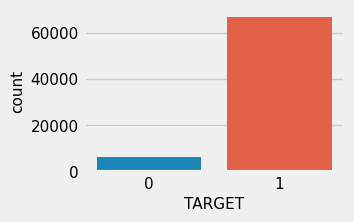

In [308]:
fig = plt.figure(figsize=(3,2))
sns.countplot(x = df['TARGET'])

plt.show()

On observe un déséquilibre très important sur les classes. On pensera donc à reéquilibrer les données d'entrainement:

### **Baseline model - Logistic Regression, Dummy Regressor**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba ,input_data ,feature_importances, seuil):
    '''This function will make a pretty plot of 
    an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.
    The threshold (seuil) here is the probability that a customer will repay his credit, 
    therefore classified as positive (or 1)'''
    if seuil:
        
        binary_pred = np.where(y_pred_proba > seuil, 1, 0)
    
        pred = binary_pred
    else:
        pred = y_pred_proba
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    #tn, fp, fn, tp
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True labels')
    plt.xlabel('Predict Labels')

    plt.subplot(222)
    roc_auc = roc_auc_score(y_true, pred ) #y_pred_proba
    fpr, tpr, _ = roc_curve(y_true, pred)   #y_pred_proba 
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    if input_data is not None and not input_data.empty and feature_importances:
        
    #if feature_importances and input_data: 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
        input_data = input_data.drop(["SK_ID_CURR", "TARGET"], axis = 1)
    
        features = []
        #input_data = input_data.drop(["SK_ID_CURR", "TARGET"], axis = 1)

        for i in range(20):
            features.append(input_data.columns[indices[i]]) #After RFECV selection > X_data created
        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
    

    plt.show()

In [20]:
%%time
from sklearn.linear_model import LogisticRegression
# Définition et entraînement du modèle de régression 
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6254
              precision    recall  f1-score   support

           0       0.25      0.00      0.00      1215
           1       0.92      1.00      0.96     13344

    accuracy                           0.92     14559
   macro avg       0.58      0.50      0.48     14559
weighted avg       0.86      0.92      0.88     14559

Wall time: 3.97 s


C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


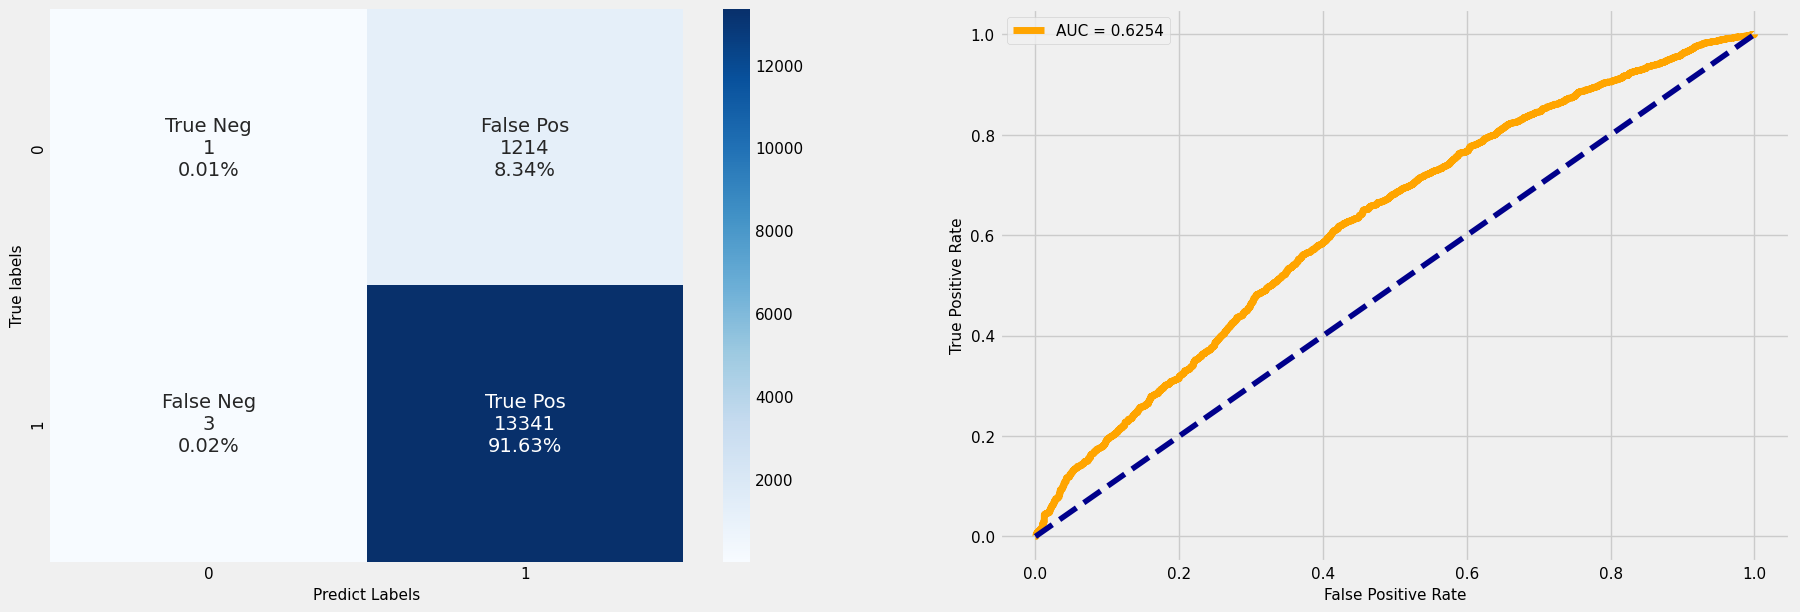

In [21]:
y_pred_proba = lr.predict_proba(X_test)[:,1]
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), y_pred_proba, input_data =df, feature_importances=None, seuil = None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0) et la Target 1 (0.92). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 , à savoir en défaut de paiement de crédit et 0.1% en modalité 1 (avant echange des étiquettes).

Il est donc intéressant de travailler en Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

### Reéquilibrons les classes en utilisant SMOTE:

In [22]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 53351 
Label 0, Before using SMOTE: 4883 


In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [24]:
print("Label 1, After using SMOTE: {} ".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {} ".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 53351 
Label 0, After using SMOTE: 53351 


### Standardisation des données:

In [25]:
from sklearn import preprocessing

# Créer l'objet StandardScaler
scaler = preprocessing.StandardScaler()

# Appliquer la mise à l'échelle aux ensembles d'entraînement et de test
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [26]:
import joblib
## sauvegarde des données d'entrainement reéquilibrées et standardisées
joblib.dump(X_train_res_scaled, 'X_train_res.joblib')
joblib.dump(y_train_res, 'y_train_res.joblib')

['y_train_res.joblib']

In [27]:
import joblib
X_train_res = joblib.load("X_train_res.joblib")
y_train_res = joblib.load("y_train_res.joblib")

In [30]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res_scaled, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test_scaled)))

AUC : 0.6697
              precision    recall  f1-score   support

           0       0.25      0.06      0.09      1215
           1       0.92      0.98      0.95     13344

    accuracy                           0.91     14559
   macro avg       0.58      0.52      0.52     14559
weighted avg       0.86      0.91      0.88     14559

Wall time: 1.71 s


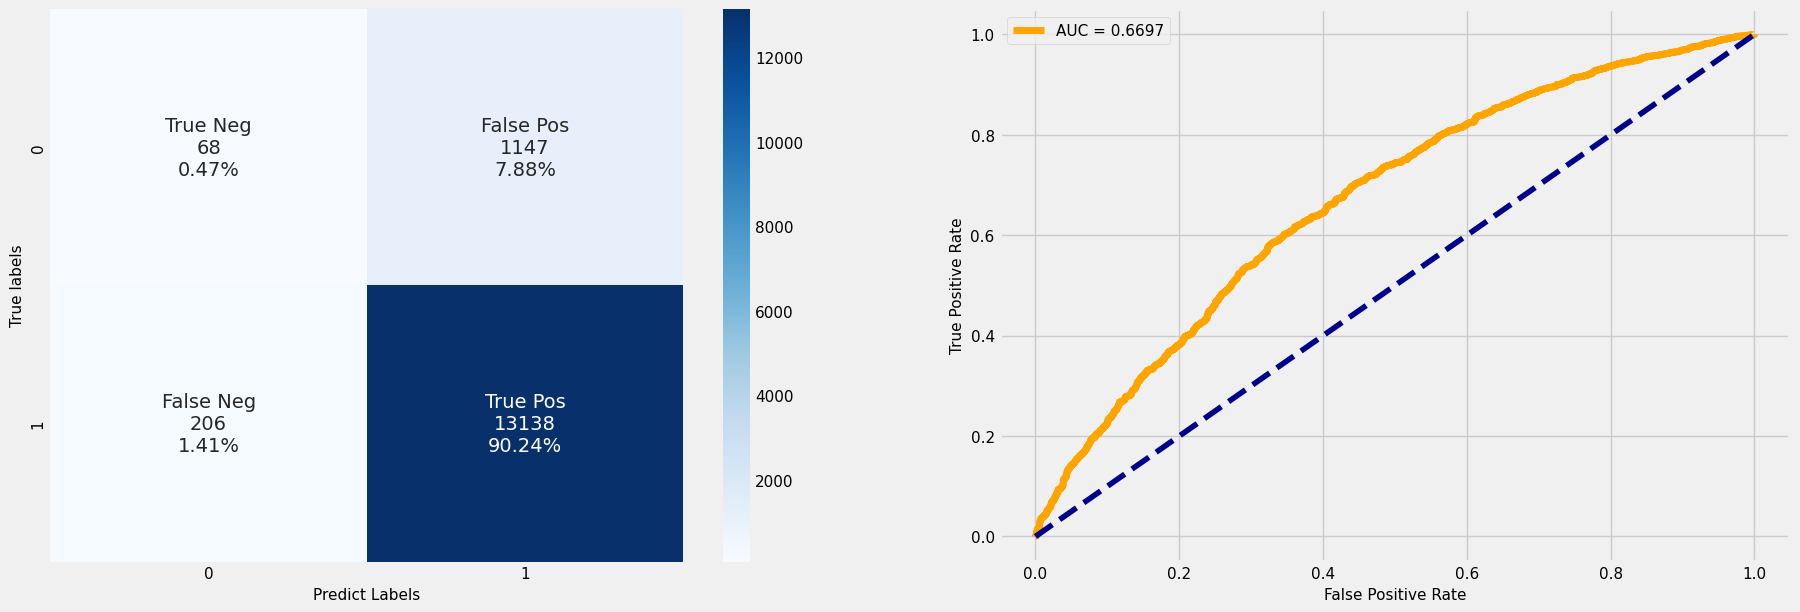

In [31]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test_scaled), lr.predict_proba(X_test_scaled)[:,1],input_data = None,
                  feature_importances=None, seuil =None)

Amélioration de l'AUC score qui est passé à 0.67, meilleur que la baseline de travail (0.62).

### DummyRegressor: modèle de base

In [32]:
dm = DummyRegressor()
dm.fit(X_train_res_scaled, y_train_res)

baseline_error = np.sqrt(np.mean((dm.predict(X_test_scaled) - y_test) ** 2))
print("Baseline Error (RMSE):", baseline_error)

pred_dm = dm.predict(X_test_scaled)
pred_dm[pred_dm <= 0.5] = 0
pred_dm[pred_dm > 0.5] = 1

print('BASELINE:')
print("AUC score:", roc_auc_score(y_test, pred_dm))
print("FBeta-score:", fbeta_score(y_test, pred_dm, average='micro', beta=0.5))

cm = confusion_matrix(y_test, pred_dm)
print('Confusion matrix\n\n', cm)
print('\nTrue Negatives(TN) =', cm[0, 0])
print('\nFalse Positives(FP) =', cm[0, 1])
print('\nFalse Negatives(FN) =', cm[1, 0])
print('\nTrue Positives(TP) =', cm[1, 1])

Baseline Error (RMSE): 0.5
BASELINE:
AUC score: 0.5
FBeta-score: 0.08345353389655882
Confusion matrix

 [[ 1215     0]
 [13344     0]]

True Negatives(TN) = 1215

False Positives(FP) = 0

False Negatives(FN) = 13344

True Positives(TP) = 0


### Modélisation: Gradient Boosting

In [33]:
#Predictive Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

models = [
          GradientBoostingClassifier(),
          LGBMClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter = 100)
         ]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [34]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      }
          
    return output

In [35]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 1h 28min 21s


In [36]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.757185,0.91689,0.918876,0.997377,0.956519,6.674541
0,GradientBoostingClassifier,0.755323,0.916821,0.917544,0.999026,0.956553,5037.746017
2,RandomForestClassifier,0.689986,0.916684,0.916672,1.0,0.956525,253.378499
3,LogisticRegression,0.624914,0.916409,0.916592,0.999775,0.956378,4.103512


LGBMClassifier l'emporte selon le couple AUC/Time.

Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [37]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res_scaled, X_test_scaled, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

Wall time: 4h 37min 42s


C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
3,LogisticRegression,0.742207,0.915722,0.917799,0.997377,0.955935,5.208523
1,LGBMClassifier,0.735579,0.91531,0.918747,0.995653,0.955655,7.846213
2,RandomForestClassifier,0.69625,0.913868,0.918397,0.994379,0.954879,184.39778
0,GradientBoostingClassifier,0.689217,0.912219,0.918319,0.992506,0.953972,16464.595124


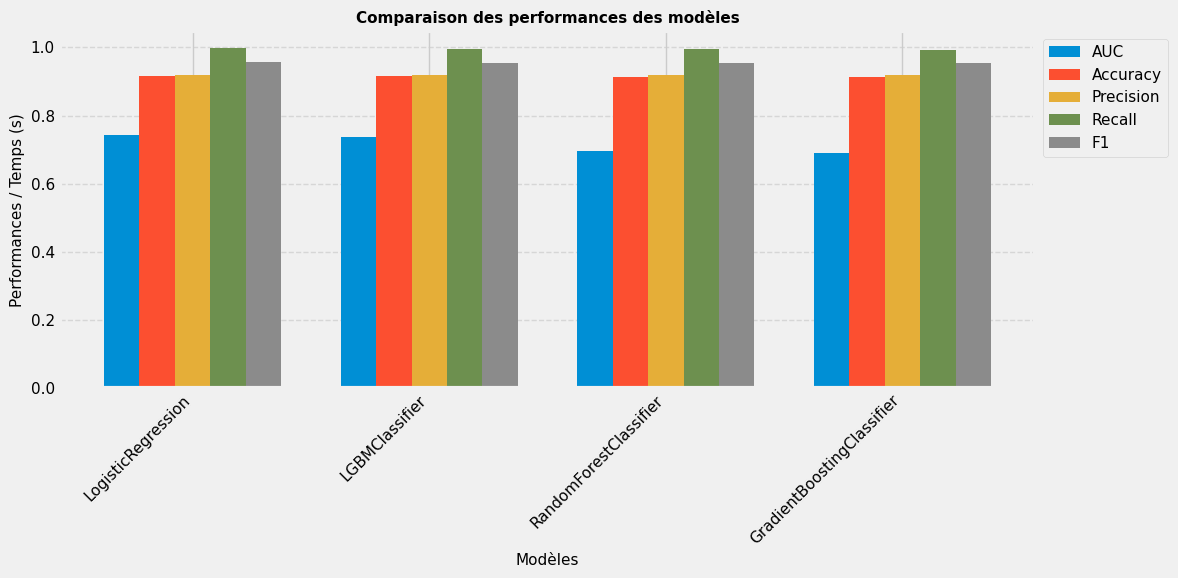

In [39]:
import matplotlib.pyplot as plt

# Noms des modèles pour l'axe des x
model_names = models_res['Model']

# Métriques à comparer, y compris le temps d'exécution
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']

# Valeurs de chaque métrique pour chaque modèle
metric_values = models_res[metrics].values.T

# Créer la figure
plt.figure(figsize=(12, 6))

# Position des barres groupées pour chaque métrique
bar_width = 0.15
positions = range(len(model_names))

# Créer les barres groupées pour chaque métrique
for i, metric in enumerate(metrics[:]):  # Exclure le temps d'exécution pour le moment
    plt.bar([p + i * bar_width for p in positions], metric_values[i], bar_width, label=metric)

# Ajouter une barre pour le temps d'exécution avec une couleur différente (par exemple, rouge)
#plt.bar([p + len(metrics[:-1]) * bar_width for p in positions], metric_values[-1], bar_width, label='Time', color='red')

# Personnalisation de l'axe des x et des étiquettes
plt.xlabel('Modèles')
plt.ylabel('Performances / Temps (s)')
plt.title('Comparaison des performances des modèles')
plt.xticks([p + 2 * bar_width for p in positions], model_names, rotation=45, ha='right')

# Légende
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Afficher la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()

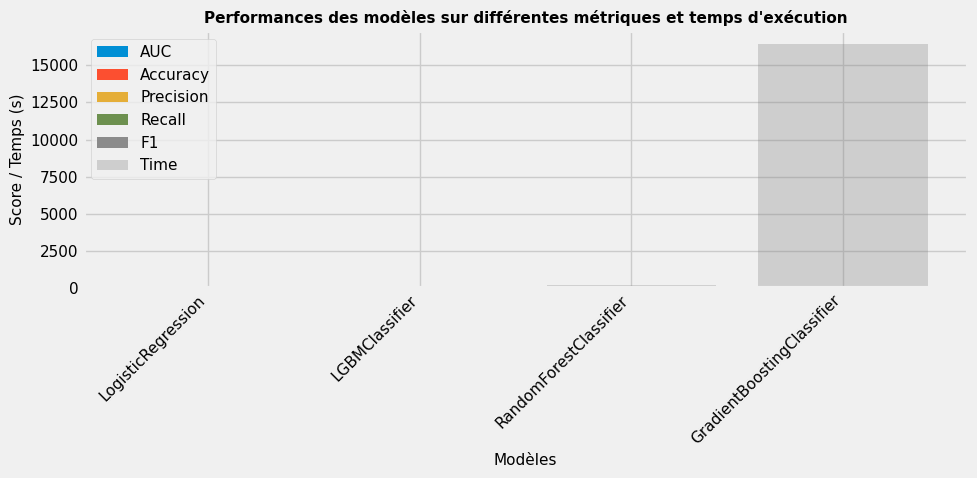

In [40]:
# Ajoutons le temps d'exécution dans le graphique à barres
metrics_with_time = metrics + ['Time']

plt.figure(figsize=(10, 5))
for metric in metrics_with_time:
    if metric == 'Time':
        plt.bar(models_res['Model'], models_res[metric], label=metric, alpha=0.3, color='gray')  # Barre grise pour le temps d'exécution
    else:
        plt.bar(models_res['Model'], models_res[metric], label=metric)

plt.xlabel('Modèles')
plt.ylabel('Score / Temps (s)')
plt.title('Performances des modèles sur différentes métriques et temps d\'exécution')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### **Feature Selection - Recursive Feature Elimination (RFECV)** 
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 497 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.


-------

On va d'abord standardiser les données puis les réequilibrer avec smote:

In [41]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [42]:

%%time

# Fixer la graine aléatoire pour NumPy
np.random.seed(42)

start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_res, y_train_res)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 481 features.
Fitting estimator with 476 features.
Fitting estimator with 471 features.
Fitting estimator with 466 features.
Fitting estimator with 461 features.
Fitting estimator with 456 features.
Fitting estimator with 451 features.
Fitting estimator with 446 features.
Fitting estimator with 441 features.
Fitting estimator with 436 features.
Fitting estimator with 431 features.
Fitting estimator with 426 features.
Fitting estimator with 421 features.
Fitting estimator with 416 features.
Fitting estimator with 411 features.
Fitting estimator with 406 features.
Fitting estimator with 401 features.
Fitting estimator with 396 features.
Fitting estimator with 391 features.
Fitting estimator with 386 features.
Fitting estimator with 381 features.
Fitting estimator with 376 features.
Fitting estimator with 371 features.
Fitting estimator with 366 features.
Fitting estimator with 361 features.
Fitting estimator with 356 features.
Fitting estimator with 351 features.
F

In [43]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 111
Selected Features: [ True  True  True  True  True  True  True  True  True False  True False
  True False  True  True False False False False]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1 31  1 31  1  3  1  1  3 32 33 11]


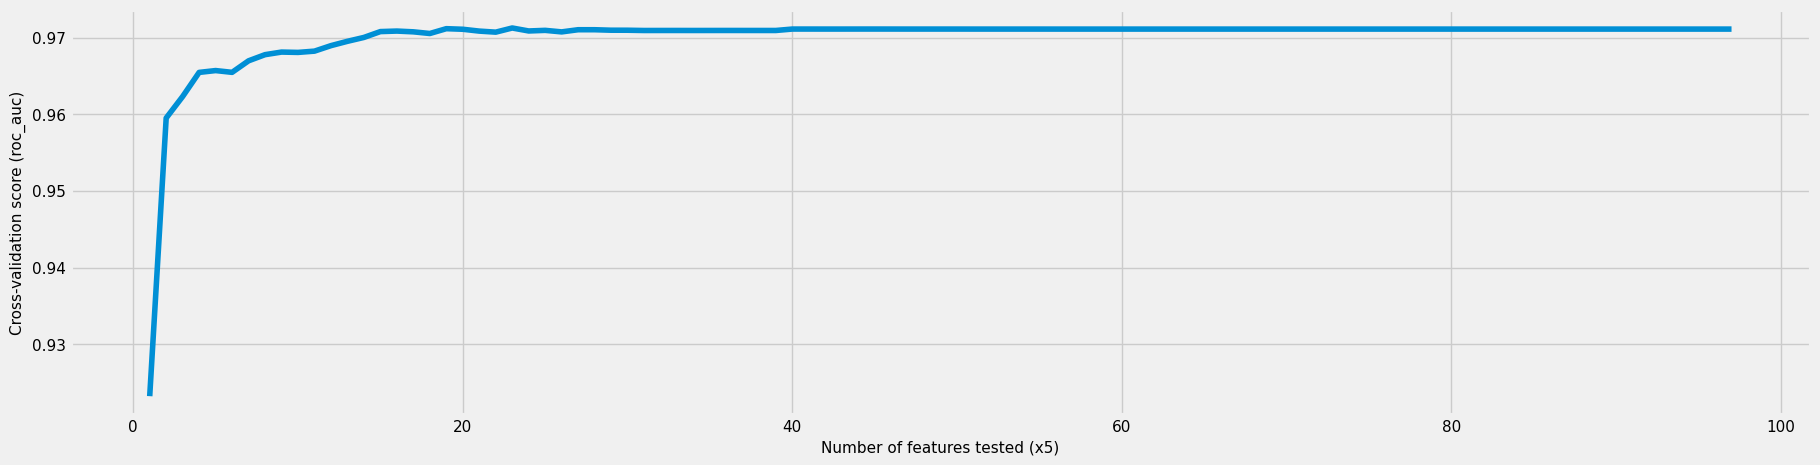

In [44]:
#Plot number of features vs CV scores
step = 5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')

plt.show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également la figure ci-dessus.

In [45]:

ranking = pd.DataFrame({'Features': df.drop(['SK_ID_CURR', 'TARGET'], axis = 1).columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

111
['CODE_GENDER', 'BURO_CREDIT_TYPE_Creditcard_MEAN', 'BURO_CREDIT_TYPE_Microloan_MEAN', 'PREV_AMT_CREDIT_MIN', 'PREV_AMT_CREDIT_MAX', 'PREV_HOUR_APPR_PROCESS_START_MIN', 'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_DAYS_DECISION_MIN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'ORGANIZATION_TYPE_BusinessEntityType3', 'ORGANIZATION_TYPE_Selfemployed',

In [46]:
df_train = df.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
df_select = df.loc[:, df_train.columns[rfecv.get_support()]]
df_select.shape

(72793, 111)

Récupérons seulement les noms des features séléctionnées par rfecv: 

In [47]:
columns_selected = df_select.columns

Nous allons refaire l'étude mais en utilisant les variables séléctionnées par RFECV:

In [48]:
df_selected =pd.merge(df[['SK_ID_CURR', 'TARGET']], df[columns_selected], left_index=True, right_index=True)
df_selected.shape

(72793, 113)

Il est nécessaire de sauvegarder le dataset ``df_selected`` de manière à pouvoir le réutiliser facilement.

In [49]:
%%time
compression_opts = dict(method='zip', archive_name='df_selected.csv')
df_selected.to_csv('notebooks_P7/Data_projet7/new_data/df_selected.zip', index=False, compression=compression_opts)

Wall time: 8.91 s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 116  best features identifiées (sans les variables "TARGET" et "SK_ID_CURR"). Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement ou pour le tableau de board.

In [50]:
# %%time
# compression_opts = dict(method='zip', archive_name='X_sample.csv')
# df_selected.sample(900).to_csv('notebooks_P7/Data_projet7/new_data/X_sample.zip', index=False, compression=compression_opts)

In [222]:
z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

In [223]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(X_data.head(5))

Aperçu des premières lignes du DataFrame :
   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100011       1            1             0                0   
1      100023       1            1             0                0   
2      100036       1            1             0                0   
3      100043       1            1             0                0   
4      100047       0            0             0                0   

   AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0          112500.0   1019610.0                    0.018634      -20099   
1           90000.0    544491.0                    0.015221      -11348   
2          112500.0    512064.0                    0.008575      -11144   
3          198000.0    641173.5                    0.018850      -17199   
4          202500.0   1193580.0                    0.025164      -17482   

   DAYS_REGISTRATION  ...  CC_AMT_DRAWINGS_ATM_CURRENT_SUM  \
0            -7427.0  ...    

In [267]:
from sklearn.model_selection import train_test_split
seed = 42

#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
df_selected = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

# Séparation en données de test et d'entrainement (données completes)
seed = 42
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split( df_selected.drop(['TARGET'], axis = 1), 
                                                    df_selected['TARGET'], test_size = 0.2, random_state = seed)

In [270]:
# Ces identifiants seront necessaire pour le dashbord
SK_ID_CURR_selected = X_test_select['SK_ID_CURR'].to_frame()

In [274]:
# Supprimons cette colonne des data sets d'entrainement et de test
X_train_select.drop("SK_ID_CURR", axis = 1, inplace = True)
X_test_select.drop("SK_ID_CURR", axis = 1, inplace = True)

In [55]:
# # Séparation en données de validation et d'entrainement
# X_train_select, X_val_select, y_train_select, y_val_select = train_test_split( X_train_select, 
#                                                     y_train_select, test_size = 0.30, random_state = seed)

Standardisation des données reéquilibrées après feature selection: 

In [275]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_select_scaled = scaler.fit_transform(X_train_select)
X_test_select_scaled = scaler.transform(X_test_select)

# Pour la validation:
#X_val_select_scaled = scaler.transform(X_val_select)

In [276]:
print("X train:", X_train_select_scaled.shape, "             y_train:", y_train_select.shape)

X train: (58234, 111)              y_train: (58234,)


In [277]:
# X_val_select_scaled.shape, y_val_select.shape

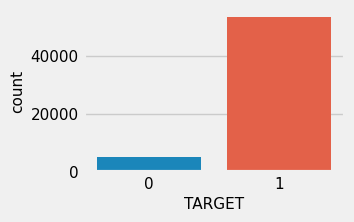

In [278]:
fig = plt.figure(figsize=(3,2))
sns.countplot(x = y_train_select)
plt.show()

Reéquibilibrons les données obténues après la selection des features réalisée avec rfecv:

In [279]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_selected, y_train_selected = smote.fit_resample(X_train_select_scaled, y_train_select)

#pour avoir la même notation:
X_test_selected = X_test_select_scaled
y_test_selected = y_test_select

# X_val_selected = X_val_select_scaled
# y_val_selected = y_val_select

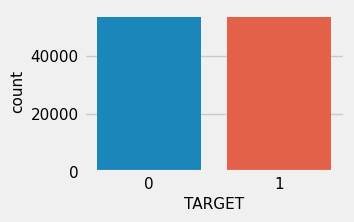

In [280]:
fig = plt.figure(figsize=(3,2))
sns.countplot(x = y_train_selected)
plt.show()

In [281]:
X_train_selected.shape, y_train_selected.shape

((106702, 111), (106702,))

In [282]:
X_test_selected.shape, y_test_selected.shape

((14559, 111), (14559,))

In [283]:
#X_val_selected.shape, y_val_selected.shape

Sauvegardons les données finales séléctionnées:

In [284]:
import joblib
joblib.dump(X_test_selected, 'notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
joblib.dump(y_test_selected, 'notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
joblib.dump(X_train_selected, 'notebooks_P7/Data_projet7/new_data/X_train_selected.joblib')
joblib.dump(y_train_selected, 'notebooks_P7/Data_projet7/new_data/y_train_selected.joblib')

# Données de Validation

# joblib.dump(X_val_selected, 'notebooks_P7/Data_projet7/new_data/X_val_selected.joblib')
# joblib.dump(y_val_selected, 'notebooks_P7/Data_projet7/new_data/y_val_selected.joblib')

['notebooks_P7/Data_projet7/new_data/y_train_selected.joblib']

In [285]:
%%time

#Predictive Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

models = [
          GradientBoostingClassifier(),
          LGBMClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter =100)
         ]


name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

Wall time: 9min 19s


In [286]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.738791,0.915791,0.918902,0.996028,0.955912,2.093673
3,LogisticRegression,0.728931,0.674566,0.956891,0.67536,0.791846,1.261474
0,GradientBoostingClassifier,0.709294,0.913868,0.919675,0.992731,0.954808,421.009722
2,RandomForestClassifier,0.704147,0.907755,0.921413,0.983213,0.951311,134.895396


In [64]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.757185,0.91689,0.918876,0.997377,0.956519,6.674541
0,GradientBoostingClassifier,0.755323,0.916821,0.917544,0.999026,0.956553,5037.746017
2,RandomForestClassifier,0.689986,0.916684,0.916672,1.0,0.956525,253.378499
3,LogisticRegression,0.624914,0.916409,0.916592,0.999775,0.956378,4.103512


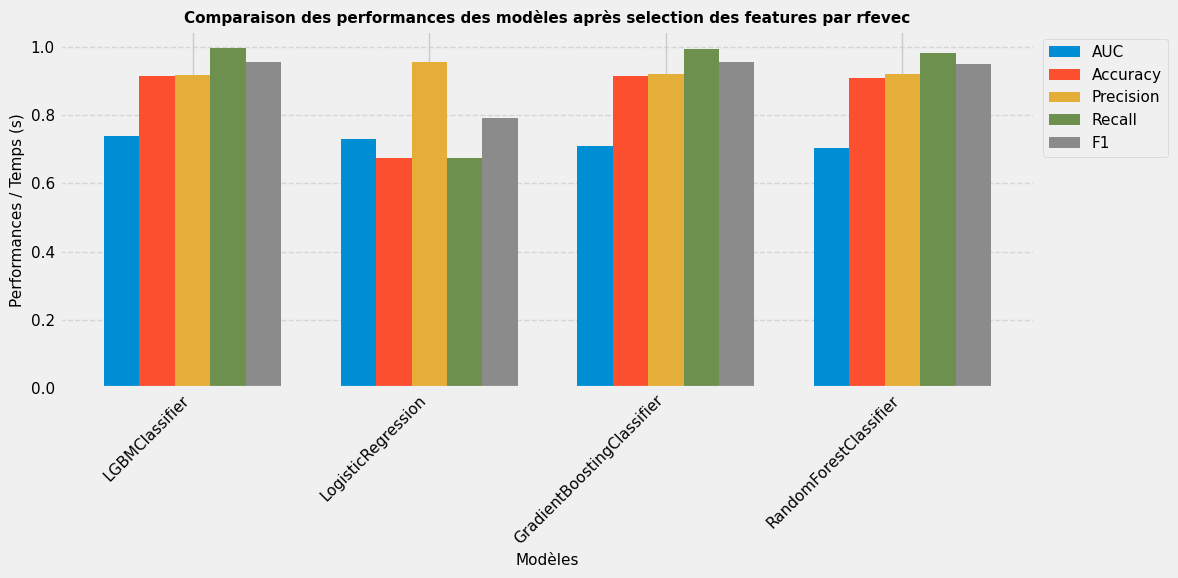

In [287]:
import matplotlib.pyplot as plt

# Noms des modèles pour l'axe des x
model_names = models_rfe['Model']

# Métriques à comparer
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']

# Valeurs de chaque métrique pour chaque modèle
metric_values = models_rfe[metrics].values.T

# Créer la figure
plt.figure(figsize=(12, 6))

# Position des barres groupées pour chaque métrique
bar_width = 0.15
positions = range(len(model_names))

# Créer les barres groupées pour chaque métrique
for i, metric in enumerate(metrics[:]):  
    plt.bar([p + i * bar_width for p in positions], metric_values[i], bar_width, label=metric)

# Ajouter une barre pour le temps d'exécution avec une couleur différente (par exemple, rouge)
#plt.bar([p + len(metrics[:-1]) * bar_width for p in positions], metric_values[-1], bar_width, label='Time', color='red')

# Personnalisation de l'axe des x et des étiquettes
plt.xlabel('Modèles')
plt.ylabel('Performances / Temps (s)')
plt.title('Comparaison des performances des modèles après selection des features par rfevec')
plt.xticks([p + 2 * bar_width for p in positions], model_names, rotation=45, ha='right')

# Légende
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Afficher la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()

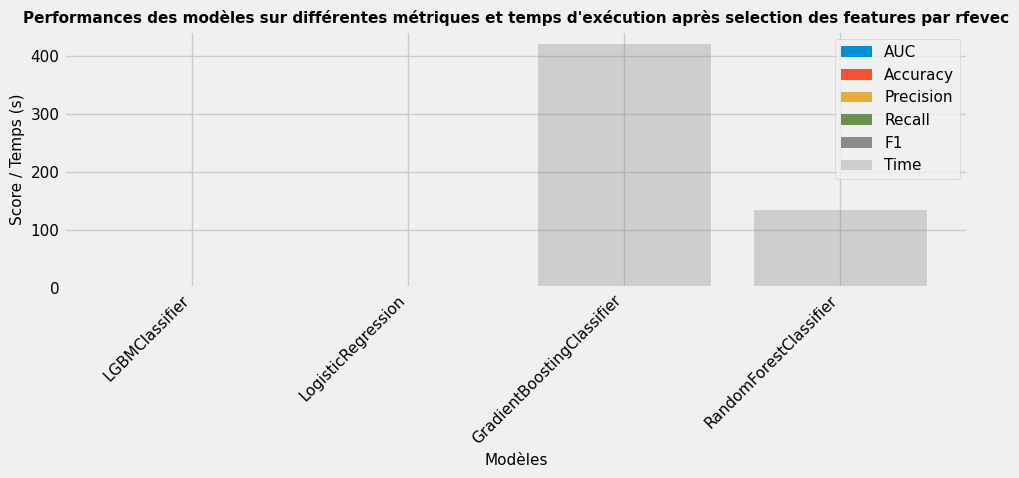

In [288]:
# Ajoutons le temps d'exécution dans le graphique à barres
metrics_with_time = metrics + ['Time']

plt.figure(figsize=(10, 5))
for metric in metrics_with_time:
    if metric == 'Time':
        plt.bar(models_rfe['Model'], models_rfe[metric], label=metric, alpha=0.3, color='gray')  # Barre grise pour le temps d'exécution
    else:
        plt.bar(models_rfe['Model'], models_rfe[metric], label=metric)

plt.xlabel('Modèles')
plt.ylabel('Score / Temps (s)')
plt.title('Performances des modèles sur différentes métriques et temps d\'exécution après selection des features par rfevec')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time. GradientBoostingClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel.

----
Dans la partie suivante on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique 'métier' d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{{Beta}^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
\begin{aligned}{\text{Fscore}}&= (1 + {beta})*{\frac {precision.recall}{{Beta}^2.precision + recall}}\,&=(1+{Beta}^2) . {\frac {tp}{(1+{Beta}^2).tp + {Beta}^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3** si on utilisait le F-Beta score ou une métrique similaire.

### Définition d'un score "métier": 

In [289]:
# On définit un,e première métrique métier:
from sklearn.metrics import make_scorer
from sklearn import metrics

# Définition des coûts de classification personnalisés
 #   cout_fp   # Coût associé à un faux positif (prédire que le client est solvable alors qu'il ne l'est pas)
 #   cout_fn   # Coût associé à un faux négatif (prédire que le client fait faillite alors qu'il est solvable)
    
def metric_banking_1(y_test, y_pred, cout_fp = 10, cout_fn = 1):
    cm = confusion_matrix(y_test, y_pred)
    
    # Sensibilité (taux de vrais positifs)
    sensibilite = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    
    # Spécificité (taux de vrais négatifs)
    #specificite = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    # Métrique ajustée pour optimiser les vrais positifs et pénaliser les faux positifs et les faux négatifs
    metric = sensibilite - cout_fp * cm[0, 1] - cout_fn * cm[1, 0]
    
    return 1 - metric

#sklearn make_scorer for the banque_score
credit_score_1 = metrics.make_scorer(metric_banking_1, greater_is_better = False)

In [290]:
# tests focntionnels de la métrique
from sklearn.metrics import confusion_matrix
import numpy as np
# Exemple de vraies étiquettes de test et de prédictions (0 = négatif, 1 = positif)
y_test_t = np.array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])
y_pred_t = np.array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

# Testez différentes valeurs pour les coûts FP et FN
cout_fp = 10   # Coût associé aux faux positifs
cout_fn_values = [1, 2, 5]    # Coûts associés aux faux négatifs

for cout_fn in cout_fn_values:
    # Calculer la métrique pour chaque combinaison de coûts
    score = metric_banking_1(y_test_t, y_pred_t, cout_fp, cout_fn)
    print(f"Coût FP = {cout_fp}, Coût FN = {cout_fn}, Métrique = {score}")

Coût FP = 10, Coût FN = 1, Métrique = 21.2
Coût FP = 10, Coût FN = 2, Métrique = 22.2
Coût FP = 10, Coût FN = 5, Métrique = 25.2


On choisit donc cout_fp = 10 et cout_fn = 1 pour avoir un meilleur score car on voudrait minimiser cette fonction.

In [291]:
def metric_banking_2(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

#sklearn make_scorer for the banque_score
credit_score_2 = metrics.make_scorer(metric_banking_2, greater_is_better = False)

In [292]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

In [293]:
# tests focntionnels de la métrique
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
import numpy as np

# Exemple de vraies étiquettes de test et de prédictions (0 = négatif, 1 = positif)
y_test_t = np.array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])
y_pred_t = np.array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

# Calculez la matrice de confusion
cm = confusion_matrix(y_test_t, y_pred_t)
print("Confusion Matrix:")
print(cm)

# Coûts associés aux faux positifs et aux faux négatifs
cout_fp = 10
cout_fn = 1

# Calculez la sensibilité (Recall) et la métrique metric_banking_1
sensibilite = cm[1, 1] / (cm[1, 1] + cm[1, 0])
metric = sensibilite - cout_fp * cm[0, 1]
print("Sensibilité (Recall):", sensibilite)
print("Métrique metric_banking_1:", metric_banking_1(y_test_t, y_pred_t, cout_fp = 10, cout_fn = 5))

Confusion Matrix:
[[3 2]
 [1 4]]
Sensibilité (Recall): 0.8
Métrique metric_banking_1: 25.2


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score moins importants.

### LgbmClassifier avant l'optimisation des hyperparamètres:

In [309]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [310]:
cost_false(lgbm, y_test, X_test)

False Pos: 8.07%
False Neg: 0.24%


(0.08070609245140463, 0.002404011264509925)

### **Hyperparameters tunning - Hyperopt et credit score ("score métier")**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié. On explorera Grid Search aussi.


In [311]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

#### 1ere mise en place de recherche des meilleurs hyperparamètres:

In [312]:
import joblib
X_train_selected = joblib.load("notebooks_P7/Data_projet7/new_data/X_train_selected.joblib")
y_train_selected = joblib.load("notebooks_P7/Data_projet7/new_data/y_train_selected.joblib")

X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')

# X_val_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_val_selected.joblib')
# y_val_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_val_selected.joblib')

z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

In [313]:
X_train_selected.shape, y_train_selected.shape

((106702, 111), (106702,))

In [314]:

# Définir l'espace des hyperparamètres à explorer
seed = 42
space = {
    'num_boost_round': hp.quniform('num_boost_round', 50, 200, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 100, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

# Définir la fonction objectif à minimiser

def objective_1(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'num_boost_round': int(params['num_boost_round']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        #'device':'gpu'
        }
    
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    
    
    # Cross-validation pour estimer les performances du modèle
    cv_scores = cross_val_score(model, X_train_selected, y_train_selected, cv=cv, 
                             
                             scoring=credit_score_1
                             
                            )
    
    avg_score = cv_scores.mean()
    return {'loss': 1 - avg_score, 'status': STATUS_OK} 

In [315]:
# Créer une instance de Trials pour enregistrer les résultats de chaque essai
trials = Trials()

# Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
best = fmin(fn=objective_1, space=space, algo=tpe.suggest, max_evals=100,  # Nombre d'essais d'hyperparamètres à effectuer
    trials=trials
)

[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
  0%|                                                                          | 0/100 [00:01<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
  0%|                                                                          | 0/100 [00:03<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
  0%|                                                                          | 0/100 [00:05<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
  0%|                                                                          | 0/100 [00:07<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=87, num_boost_round=87 will be ignored. Current value: num_iterations=87    
  1%|▍                                               | 1/100 [00:08<14:36,  8.85s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=87, num_boost_round=87 will be ignored. Current value: num_iterations=87    
  1%|▍                                               | 1/100 [00:10<14:36,  8.85s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=87, num_boost_round=87 will be ignored. Current value: num_iterations=87    
  1%|▍                                               | 1/100 [00:11<14:36,  8.85s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=87, num_boost_round=87 will be ignored. Current value: num_iterations=87    
  1%|▍                                               | 1/100 [00:13<14:36,  8.85s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=87, num_boost_round=87 will be ignored. Current value: num_iterations=87    
  1%|▍                                               | 1/100 [00:14<14:36,  8.85s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
  2%|▉                                               | 2/100 [00:16<12:57,  7.94s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
  2%|▉                                               | 2/100 [00:18<12:57,  7.94s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
  2%|▉                                               | 2/100 [00:20<12:57,  7.94s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
  2%|▉                                               | 2/100 [00:22<12:57,  7.94s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
  2%|▉                                               | 2/100 [00:25<12:57,  7.94s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
  3%|█▍                                              | 3/100 [00:27<15:11,  9.40s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
  3%|█▍                                              | 3/100 [00:28<15:11,  9.40s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
  3%|█▍                                              | 3/100 [00:29<15:11,  9.40s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
  3%|█▍                                              | 3/100 [00:31<15:11,  9.40s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
  3%|█▍                                              | 3/100 [00:32<15:11,  9.40s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=132, num_boost_round=132 will be ignored. Current value: num_iterations=132 
  4%|█▉                                              | 4/100 [00:34<13:28,  8.42s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=132, num_boost_round=132 will be ignored. Current value: num_iterations=132 
  4%|█▉                                              | 4/100 [00:36<13:28,  8.42s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=132, num_boost_round=132 will be ignored. Current value: num_iterations=132 
  4%|█▉                                              | 4/100 [00:38<13:28,  8.42s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=132, num_boost_round=132 will be ignored. Current value: num_iterations=132 
  4%|█▉                                              | 4/100 [00:41<13:28,  8.42s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=132, num_boost_round=132 will be ignored. Current value: num_iterations=132 
  4%|█▉                                              | 4/100 [00:43<13:28,  8.42s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
  5%|██▍                                             | 5/100 [00:45<14:56,  9.44s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
  5%|██▍                                             | 5/100 [00:47<14:56,  9.44s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
  5%|██▍                                             | 5/100 [00:48<14:56,  9.44s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
  5%|██▍                                             | 5/100 [00:50<14:56,  9.44s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
  5%|██▍                                             | 5/100 [00:51<14:56,  9.44s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
  6%|██▉                                             | 6/100 [00:53<13:44,  8.77s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
  6%|██▉                                             | 6/100 [00:54<13:44,  8.77s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
  6%|██▉                                             | 6/100 [00:56<13:44,  8.77s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
  6%|██▉                                             | 6/100 [00:58<13:44,  8.77s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
  6%|██▉                                             | 6/100 [00:59<13:44,  8.77s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
  7%|███▎                                            | 7/100 [01:01<13:34,  8.76s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
  7%|███▎                                            | 7/100 [01:03<13:34,  8.76s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
  7%|███▎                                            | 7/100 [01:05<13:34,  8.76s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
  7%|███▎                                            | 7/100 [01:08<13:34,  8.76s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
  7%|███▎                                            | 7/100 [01:10<13:34,  8.76s/trial, best loss: 10891.030927508331]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=105, num_boost_round=105 will be ignored. Current value: num_iterations=105 
  8%|███▊                                            | 8/100 [01:12<14:17,  9.32s/trial, best loss: 10882.030084051783]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=105, num_boost_round=105 will be ignored. Current value: num_iterations=105 
  8%|███▊                                            | 8/100 [01:14<14:17,  9.32s/trial, best loss: 10882.030084051783]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=105, num_boost_round=105 will be ignored. Current value: num_iterations=105 
  8%|███▊                                            | 8/100 [01:16<14:17,  9.32s/trial, best loss: 10882.030084051783]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=105, num_boost_round=105 will be ignored. Current value: num_iterations=105 
  8%|███▊                                            | 8/100 [01:18<14:17,  9.32s/trial, best loss: 10882.030084051783]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=105, num_boost_round=105 will be ignored. Current value: num_iterations=105 
  8%|███▊                                            | 8/100 [01:20<14:17,  9.32s/trial, best loss: 10882.030084051783]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=53, num_boost_round=53 will be ignored. Current value: num_iterations=53    
  9%|████▎                                           | 9/100 [01:22<14:35,  9.62s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=53, num_boost_round=53 will be ignored. Current value: num_iterations=53    
  9%|████▎                                           | 9/100 [01:23<14:35,  9.62s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=53, num_boost_round=53 will be ignored. Current value: num_iterations=53    
  9%|████▎                                           | 9/100 [01:24<14:35,  9.62s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=53, num_boost_round=53 will be ignored. Current value: num_iterations=53    
  9%|████▎                                           | 9/100 [01:25<14:35,  9.62s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=53, num_boost_round=53 will be ignored. Current value: num_iterations=53    
  9%|████▎                                           | 9/100 [01:26<14:35,  9.62s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92    
 10%|████▋                                          | 10/100 [01:27<12:21,  8.24s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92    
 10%|████▋                                          | 10/100 [01:29<12:21,  8.24s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92    
 10%|████▋                                          | 10/100 [01:31<12:21,  8.24s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92    
 10%|████▋                                          | 10/100 [01:32<12:21,  8.24s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92    
 10%|████▋                                          | 10/100 [01:34<12:21,  8.24s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=119, num_boost_round=119 will be ignored. Current value: num_iterations=119 
 11%|█████▏                                         | 11/100 [01:36<12:29,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=119, num_boost_round=119 will be ignored. Current value: num_iterations=119 
 11%|█████▏                                         | 11/100 [01:38<12:29,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=119, num_boost_round=119 will be ignored. Current value: num_iterations=119 
 11%|█████▏                                         | 11/100 [01:40<12:29,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=119, num_boost_round=119 will be ignored. Current value: num_iterations=119 
 11%|█████▏                                         | 11/100 [01:42<12:29,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=119, num_boost_round=119 will be ignored. Current value: num_iterations=119 
 11%|█████▏                                         | 11/100 [01:44<12:29,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
 12%|█████▋                                         | 12/100 [01:47<13:16,  9.05s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
 12%|█████▋                                         | 12/100 [01:48<13:16,  9.05s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
 12%|█████▋                                         | 12/100 [01:50<13:16,  9.05s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
 12%|█████▋                                         | 12/100 [01:52<13:16,  9.05s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
 12%|█████▋                                         | 12/100 [01:54<13:16,  9.05s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 13%|██████                                         | 13/100 [01:55<13:01,  8.98s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 13%|██████                                         | 13/100 [01:57<13:01,  8.98s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 13%|██████                                         | 13/100 [01:58<13:01,  8.98s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 13%|██████                                         | 13/100 [01:59<13:01,  8.98s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 13%|██████                                         | 13/100 [02:01<13:01,  8.98s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 14%|██████▌                                        | 14/100 [02:02<12:03,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 14%|██████▌                                        | 14/100 [02:04<12:03,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 14%|██████▌                                        | 14/100 [02:05<12:03,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 14%|██████▌                                        | 14/100 [02:06<12:03,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 14%|██████▌                                        | 14/100 [02:08<12:03,  8.42s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=112, num_boost_round=112 will be ignored. Current value: num_iterations=112 
 15%|███████                                        | 15/100 [02:09<11:04,  7.82s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=112, num_boost_round=112 will be ignored. Current value: num_iterations=112 
 15%|███████                                        | 15/100 [02:10<11:04,  7.82s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=112, num_boost_round=112 will be ignored. Current value: num_iterations=112 
 15%|███████                                        | 15/100 [02:12<11:04,  7.82s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=112, num_boost_round=112 will be ignored. Current value: num_iterations=112 
 15%|███████                                        | 15/100 [02:13<11:04,  7.82s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=112, num_boost_round=112 will be ignored. Current value: num_iterations=112 
 15%|███████                                        | 15/100 [02:15<11:04,  7.82s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 16%|███████▌                                       | 16/100 [02:16<10:47,  7.70s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 16%|███████▌                                       | 16/100 [02:19<10:47,  7.70s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 16%|███████▌                                       | 16/100 [02:22<10:47,  7.70s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 16%|███████▌                                       | 16/100 [02:24<10:47,  7.70s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 16%|███████▌                                       | 16/100 [02:27<10:47,  7.70s/trial, best loss: 10591.033739066468]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55    
 17%|███████▉                                       | 17/100 [02:31<13:22,  9.67s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55    
 17%|███████▉                                       | 17/100 [02:32<13:22,  9.67s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55    
 17%|███████▉                                       | 17/100 [02:33<13:22,  9.67s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55    
 17%|███████▉                                       | 17/100 [02:34<13:22,  9.67s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55    
 17%|███████▉                                       | 17/100 [02:35<13:22,  9.67s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 18%|████████▍                                      | 18/100 [02:36<11:37,  8.51s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 18%|████████▍                                      | 18/100 [02:39<11:37,  8.51s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 18%|████████▍                                      | 18/100 [02:45<11:37,  8.51s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 18%|████████▍                                      | 18/100 [02:49<11:37,  8.51s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 18%|████████▍                                      | 18/100 [02:53<11:37,  8.51s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 19%|████████▉                                      | 19/100 [02:56<16:03, 11.90s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 19%|████████▉                                      | 19/100 [02:58<16:03, 11.90s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 19%|████████▉                                      | 19/100 [03:00<16:03, 11.90s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 19%|████████▉                                      | 19/100 [03:02<16:03, 11.90s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 19%|████████▉                                      | 19/100 [03:03<16:03, 11.90s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=149, num_boost_round=149 will be ignored. Current value: num_iterations=149 
 20%|█████████▍                                     | 20/100 [03:05<14:42, 11.03s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=149, num_boost_round=149 will be ignored. Current value: num_iterations=149 
 20%|█████████▍                                     | 20/100 [03:08<14:42, 11.03s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=149, num_boost_round=149 will be ignored. Current value: num_iterations=149 
 20%|█████████▍                                     | 20/100 [03:11<14:42, 11.03s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=149, num_boost_round=149 will be ignored. Current value: num_iterations=149 
 20%|█████████▍                                     | 20/100 [03:15<14:42, 11.03s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=149, num_boost_round=149 will be ignored. Current value: num_iterations=149 
 20%|█████████▍                                     | 20/100 [03:18<14:42, 11.03s/trial, best loss: 10416.218856484353]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=147, num_boost_round=147 will be ignored. Current value: num_iterations=147 
 21%|█████████▊                                     | 21/100 [03:23<17:03, 12.96s/trial, best loss: 10013.413533223425]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=147, num_boost_round=147 will be ignored. Current value: num_iterations=147 
 21%|█████████▊                                     | 21/100 [03:26<17:03, 12.96s/trial, best loss: 10013.413533223425]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=147, num_boost_round=147 will be ignored. Current value: num_iterations=147 
 21%|█████████▊                                     | 21/100 [03:30<17:03, 12.96s/trial, best loss: 10013.413533223425]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=147, num_boost_round=147 will be ignored. Current value: num_iterations=147 
 21%|█████████▊                                     | 21/100 [03:34<17:03, 12.96s/trial, best loss: 10013.413533223425]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=147, num_boost_round=147 will be ignored. Current value: num_iterations=147 
 21%|█████████▊                                     | 21/100 [03:37<17:03, 12.96s/trial, best loss: 10013.413533223425]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=145, num_boost_round=145 will be ignored. Current value: num_iterations=145 
 22%|██████████▌                                     | 22/100 [03:41<19:00, 14.62s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=145, num_boost_round=145 will be ignored. Current value: num_iterations=145 
 22%|██████████▌                                     | 22/100 [03:44<19:00, 14.62s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=145, num_boost_round=145 will be ignored. Current value: num_iterations=145 
 22%|██████████▌                                     | 22/100 [03:47<19:00, 14.62s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=145, num_boost_round=145 will be ignored. Current value: num_iterations=145 
 22%|██████████▌                                     | 22/100 [03:50<19:00, 14.62s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=145, num_boost_round=145 will be ignored. Current value: num_iterations=145 
 22%|██████████▌                                     | 22/100 [03:54<19:00, 14.62s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150 
 23%|███████████                                     | 23/100 [03:57<19:23, 15.11s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150 
 23%|███████████                                     | 23/100 [04:01<19:23, 15.11s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150 
 23%|███████████                                     | 23/100 [04:04<19:23, 15.11s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150 
 23%|███████████                                     | 23/100 [04:08<19:23, 15.11s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150 
 23%|███████████                                     | 23/100 [04:11<19:23, 15.11s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 24%|███████████▌                                    | 24/100 [04:14<19:51, 15.68s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 24%|███████████▌                                    | 24/100 [04:18<19:51, 15.68s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 24%|███████████▌                                    | 24/100 [04:22<19:51, 15.68s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 24%|███████████▌                                    | 24/100 [04:27<19:51, 15.68s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 24%|███████████▌                                    | 24/100 [04:32<19:51, 15.68s/trial, best loss: 9999.813758142596]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 25%|████████████                                    | 25/100 [04:36<21:42, 17.37s/trial, best loss: 9917.408847210647]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 25%|████████████                                    | 25/100 [04:39<21:42, 17.37s/trial, best loss: 9917.408847210647]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 25%|████████████                                    | 25/100 [04:44<21:42, 17.37s/trial, best loss: 9917.408847210647]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 25%|████████████                                    | 25/100 [04:48<21:42, 17.37s/trial, best loss: 9917.408847210647]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 25%|████████████                                    | 25/100 [04:52<21:42, 17.37s/trial, best loss: 9917.408847210647]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 26%|████████████▍                                   | 26/100 [04:56<22:36, 18.33s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 26%|████████████▍                                   | 26/100 [05:00<22:36, 18.33s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 26%|████████████▍                                   | 26/100 [05:05<22:36, 18.33s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 26%|████████████▍                                   | 26/100 [05:09<22:36, 18.33s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 26%|████████████▍                                   | 26/100 [05:13<22:36, 18.33s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 27%|████████████▉                                   | 27/100 [05:17<23:13, 19.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 27%|████████████▉                                   | 27/100 [05:20<23:13, 19.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 27%|████████████▉                                   | 27/100 [05:24<23:13, 19.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 27%|████████████▉                                   | 27/100 [05:28<23:13, 19.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 27%|████████████▉                                   | 27/100 [05:32<23:13, 19.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 28%|█████████████▍                                  | 28/100 [05:35<22:29, 18.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 28%|█████████████▍                                  | 28/100 [05:38<22:29, 18.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 28%|█████████████▍                                  | 28/100 [05:42<22:29, 18.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 28%|█████████████▍                                  | 28/100 [05:46<22:29, 18.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 28%|█████████████▍                                  | 28/100 [05:50<22:29, 18.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=197, num_boost_round=197 will be ignored. Current value: num_iterations=197 
 29%|█████████████▉                                  | 29/100 [05:54<22:18, 18.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=197, num_boost_round=197 will be ignored. Current value: num_iterations=197 
 29%|█████████████▉                                  | 29/100 [05:57<22:18, 18.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=197, num_boost_round=197 will be ignored. Current value: num_iterations=197 
 29%|█████████████▉                                  | 29/100 [06:02<22:18, 18.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=197, num_boost_round=197 will be ignored. Current value: num_iterations=197 
 29%|█████████████▉                                  | 29/100 [06:05<22:18, 18.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=197, num_boost_round=197 will be ignored. Current value: num_iterations=197 
 29%|█████████████▉                                  | 29/100 [06:08<22:18, 18.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 30%|██████████████▍                                 | 30/100 [06:12<21:33, 18.48s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 30%|██████████████▍                                 | 30/100 [06:15<21:33, 18.48s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 30%|██████████████▍                                 | 30/100 [06:19<21:33, 18.48s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 30%|██████████████▍                                 | 30/100 [06:23<21:33, 18.48s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 30%|██████████████▍                                 | 30/100 [06:27<21:33, 18.48s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 31%|██████████████▉                                 | 31/100 [06:31<21:39, 18.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 31%|██████████████▉                                 | 31/100 [06:35<21:39, 18.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 31%|██████████████▉                                 | 31/100 [06:39<21:39, 18.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 31%|██████████████▉                                 | 31/100 [06:43<21:39, 18.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 31%|██████████████▉                                 | 31/100 [06:46<21:39, 18.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 32%|███████████████▎                                | 32/100 [06:49<20:59, 18.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 32%|███████████████▎                                | 32/100 [06:53<20:59, 18.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 32%|███████████████▎                                | 32/100 [06:57<20:59, 18.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 32%|███████████████▎                                | 32/100 [07:01<20:59, 18.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 32%|███████████████▎                                | 32/100 [07:05<20:59, 18.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 33%|███████████████▊                                | 33/100 [07:09<20:57, 18.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 33%|███████████████▊                                | 33/100 [07:12<20:57, 18.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 33%|███████████████▊                                | 33/100 [07:15<20:57, 18.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 33%|███████████████▊                                | 33/100 [07:20<20:57, 18.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 33%|███████████████▊                                | 33/100 [07:24<20:57, 18.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=138, num_boost_round=138 will be ignored. Current value: num_iterations=138 
 34%|████████████████▎                               | 34/100 [07:28<20:51, 18.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=138, num_boost_round=138 will be ignored. Current value: num_iterations=138 
 34%|████████████████▎                               | 34/100 [07:31<20:51, 18.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=138, num_boost_round=138 will be ignored. Current value: num_iterations=138 
 34%|████████████████▎                               | 34/100 [07:34<20:51, 18.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=138, num_boost_round=138 will be ignored. Current value: num_iterations=138 
 34%|████████████████▎                               | 34/100 [07:37<20:51, 18.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=138, num_boost_round=138 will be ignored. Current value: num_iterations=138 
 34%|████████████████▎                               | 34/100 [07:40<20:51, 18.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 35%|████████████████▊                               | 35/100 [07:43<19:13, 17.75s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 35%|████████████████▊                               | 35/100 [07:47<19:13, 17.75s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 35%|████████████████▊                               | 35/100 [07:50<19:13, 17.75s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 35%|████████████████▊                               | 35/100 [07:54<19:13, 17.75s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 35%|████████████████▊                               | 35/100 [07:58<19:13, 17.75s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 36%|█████████████████▎                              | 36/100 [08:01<19:08, 17.94s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 36%|█████████████████▎                              | 36/100 [08:04<19:08, 17.94s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 36%|█████████████████▎                              | 36/100 [08:06<19:08, 17.94s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 36%|█████████████████▎                              | 36/100 [08:09<19:08, 17.94s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 36%|█████████████████▎                              | 36/100 [08:11<19:08, 17.94s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 37%|█████████████████▊                              | 37/100 [08:15<17:21, 16.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 37%|█████████████████▊                              | 37/100 [08:19<17:21, 16.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 37%|█████████████████▊                              | 37/100 [08:23<17:21, 16.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 37%|█████████████████▊                              | 37/100 [08:26<17:21, 16.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 37%|█████████████████▊                              | 37/100 [08:29<17:21, 16.52s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 38%|██████████████████▏                             | 38/100 [08:33<17:33, 16.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 38%|██████████████████▏                             | 38/100 [08:35<17:33, 16.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 38%|██████████████████▏                             | 38/100 [08:38<17:33, 16.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 38%|██████████████████▏                             | 38/100 [08:41<17:33, 16.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 38%|██████████████████▏                             | 38/100 [08:44<17:33, 16.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 39%|██████████████████▋                             | 39/100 [08:47<16:22, 16.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 39%|██████████████████▋                             | 39/100 [08:51<16:22, 16.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 39%|██████████████████▋                             | 39/100 [08:55<16:22, 16.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 39%|██████████████████▋                             | 39/100 [08:59<16:22, 16.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 39%|██████████████████▋                             | 39/100 [09:02<16:22, 16.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=123, num_boost_round=123 will be ignored. Current value: num_iterations=123 
 40%|███████████████████▏                            | 40/100 [09:06<16:57, 16.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=123, num_boost_round=123 will be ignored. Current value: num_iterations=123 
 40%|███████████████████▏                            | 40/100 [09:08<16:57, 16.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=123, num_boost_round=123 will be ignored. Current value: num_iterations=123 
 40%|███████████████████▏                            | 40/100 [09:09<16:57, 16.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=123, num_boost_round=123 will be ignored. Current value: num_iterations=123 
 40%|███████████████████▏                            | 40/100 [09:11<16:57, 16.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=123, num_boost_round=123 will be ignored. Current value: num_iterations=123 
 40%|███████████████████▏                            | 40/100 [09:13<16:57, 16.96s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 41%|███████████████████▋                            | 41/100 [09:15<14:25, 14.67s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 41%|███████████████████▋                            | 41/100 [09:17<14:25, 14.67s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 41%|███████████████████▋                            | 41/100 [09:20<14:25, 14.67s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 41%|███████████████████▋                            | 41/100 [09:22<14:25, 14.67s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 41%|███████████████████▋                            | 41/100 [09:25<14:25, 14.67s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 42%|████████████████████▏                           | 42/100 [09:28<13:37, 14.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 42%|████████████████████▏                           | 42/100 [09:31<13:37, 14.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 42%|████████████████████▏                           | 42/100 [09:34<13:37, 14.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 42%|████████████████████▏                           | 42/100 [09:39<13:37, 14.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 42%|████████████████████▏                           | 42/100 [09:43<13:37, 14.10s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 43%|████████████████████▋                           | 43/100 [09:46<14:37, 15.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 43%|████████████████████▋                           | 43/100 [09:49<14:37, 15.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 43%|████████████████████▋                           | 43/100 [09:51<14:37, 15.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 43%|████████████████████▋                           | 43/100 [09:54<14:37, 15.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 43%|████████████████████▋                           | 43/100 [09:57<14:37, 15.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 44%|█████████████████████                           | 44/100 [10:00<13:50, 14.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 44%|█████████████████████                           | 44/100 [10:01<13:50, 14.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 44%|█████████████████████                           | 44/100 [10:03<13:50, 14.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 44%|█████████████████████                           | 44/100 [10:04<13:50, 14.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=74, num_boost_round=74 will be ignored. Current value: num_iterations=74    
 44%|█████████████████████                           | 44/100 [10:06<13:50, 14.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 45%|█████████████████████▌                          | 45/100 [10:08<11:45, 12.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 45%|█████████████████████▌                          | 45/100 [10:11<11:45, 12.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 45%|█████████████████████▌                          | 45/100 [10:14<11:45, 12.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 45%|█████████████████████▌                          | 45/100 [10:17<11:45, 12.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 45%|█████████████████████▌                          | 45/100 [10:20<11:45, 12.83s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 46%|██████████████████████                          | 46/100 [10:23<12:05, 13.43s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 46%|██████████████████████                          | 46/100 [10:25<12:05, 13.43s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 46%|██████████████████████                          | 46/100 [10:28<12:05, 13.43s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 46%|██████████████████████                          | 46/100 [10:31<12:05, 13.43s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 46%|██████████████████████                          | 46/100 [10:34<12:05, 13.43s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=153, num_boost_round=153 will be ignored. Current value: num_iterations=153 
 47%|██████████████████████▌                         | 47/100 [10:38<12:17, 13.92s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=153, num_boost_round=153 will be ignored. Current value: num_iterations=153 
 47%|██████████████████████▌                         | 47/100 [10:41<12:17, 13.92s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=153, num_boost_round=153 will be ignored. Current value: num_iterations=153 
 47%|██████████████████████▌                         | 47/100 [10:45<12:17, 13.92s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=153, num_boost_round=153 will be ignored. Current value: num_iterations=153 
 47%|██████████████████████▌                         | 47/100 [10:49<12:17, 13.92s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=153, num_boost_round=153 will be ignored. Current value: num_iterations=153 
 47%|██████████████████████▌                         | 47/100 [10:53<12:17, 13.92s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=103, num_boost_round=103 will be ignored. Current value: num_iterations=103 
 48%|███████████████████████                         | 48/100 [10:57<13:23, 15.46s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=103, num_boost_round=103 will be ignored. Current value: num_iterations=103 
 48%|███████████████████████                         | 48/100 [10:58<13:23, 15.46s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=103, num_boost_round=103 will be ignored. Current value: num_iterations=103 
 48%|███████████████████████                         | 48/100 [11:00<13:23, 15.46s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=103, num_boost_round=103 will be ignored. Current value: num_iterations=103 
 48%|███████████████████████                         | 48/100 [11:02<13:23, 15.46s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=103, num_boost_round=103 will be ignored. Current value: num_iterations=103 
 48%|███████████████████████                         | 48/100 [11:03<13:23, 15.46s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 49%|███████████████████████▌                        | 49/100 [11:05<11:21, 13.36s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 49%|███████████████████████▌                        | 49/100 [11:08<11:21, 13.36s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 49%|███████████████████████▌                        | 49/100 [11:11<11:21, 13.36s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 49%|███████████████████████▌                        | 49/100 [11:14<11:21, 13.36s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190 
 49%|███████████████████████▌                        | 49/100 [11:17<11:21, 13.36s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=84, num_boost_round=84 will be ignored. Current value: num_iterations=84    
 50%|████████████████████████                        | 50/100 [11:20<11:30, 13.81s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=84, num_boost_round=84 will be ignored. Current value: num_iterations=84    
 50%|████████████████████████                        | 50/100 [11:22<11:30, 13.81s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=84, num_boost_round=84 will be ignored. Current value: num_iterations=84    
 50%|████████████████████████                        | 50/100 [11:24<11:30, 13.81s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=84, num_boost_round=84 will be ignored. Current value: num_iterations=84    
 50%|████████████████████████                        | 50/100 [11:27<11:30, 13.81s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=84, num_boost_round=84 will be ignored. Current value: num_iterations=84    
 50%|████████████████████████                        | 50/100 [11:29<11:30, 13.81s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 51%|████████████████████████▍                       | 51/100 [11:31<10:30, 12.87s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 51%|████████████████████████▍                       | 51/100 [11:34<10:30, 12.87s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 51%|████████████████████████▍                       | 51/100 [11:38<10:30, 12.87s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 51%|████████████████████████▍                       | 51/100 [11:42<10:30, 12.87s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 51%|████████████████████████▍                       | 51/100 [11:46<10:30, 12.87s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
 52%|████████████████████████▉                       | 52/100 [11:51<12:01, 15.04s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
 52%|████████████████████████▉                       | 52/100 [11:54<12:01, 15.04s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
 52%|████████████████████████▉                       | 52/100 [11:57<12:01, 15.04s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
 52%|████████████████████████▉                       | 52/100 [12:01<12:01, 15.04s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=170, num_boost_round=170 will be ignored. Current value: num_iterations=170 
 52%|████████████████████████▉                       | 52/100 [12:05<12:01, 15.04s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=141, num_boost_round=141 will be ignored. Current value: num_iterations=141 
 53%|█████████████████████████▍                      | 53/100 [12:09<12:27, 15.90s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=141, num_boost_round=141 will be ignored. Current value: num_iterations=141 
 53%|█████████████████████████▍                      | 53/100 [12:12<12:27, 15.90s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=141, num_boost_round=141 will be ignored. Current value: num_iterations=141 
 53%|█████████████████████████▍                      | 53/100 [12:15<12:27, 15.90s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=141, num_boost_round=141 will be ignored. Current value: num_iterations=141 
 53%|█████████████████████████▍                      | 53/100 [12:18<12:27, 15.90s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=141, num_boost_round=141 will be ignored. Current value: num_iterations=141 
 53%|█████████████████████████▍                      | 53/100 [12:21<12:27, 15.90s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=155, num_boost_round=155 will be ignored. Current value: num_iterations=155 
 54%|█████████████████████████▉                      | 54/100 [12:25<12:10, 15.88s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=155, num_boost_round=155 will be ignored. Current value: num_iterations=155 
 54%|█████████████████████████▉                      | 54/100 [12:27<12:10, 15.88s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=155, num_boost_round=155 will be ignored. Current value: num_iterations=155 
 54%|█████████████████████████▉                      | 54/100 [12:29<12:10, 15.88s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=155, num_boost_round=155 will be ignored. Current value: num_iterations=155 
 54%|█████████████████████████▉                      | 54/100 [12:31<12:10, 15.88s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=155, num_boost_round=155 will be ignored. Current value: num_iterations=155 
 54%|█████████████████████████▉                      | 54/100 [12:33<12:10, 15.88s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 55%|██████████████████████████▍                     | 55/100 [12:35<10:41, 14.26s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 55%|██████████████████████████▍                     | 55/100 [12:38<10:41, 14.26s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 55%|██████████████████████████▍                     | 55/100 [12:41<10:41, 14.26s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 55%|██████████████████████████▍                     | 55/100 [12:43<10:41, 14.26s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 55%|██████████████████████████▍                     | 55/100 [12:47<10:41, 14.26s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=165, num_boost_round=165 will be ignored. Current value: num_iterations=165 
 56%|██████████████████████████▉                     | 56/100 [12:50<10:32, 14.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=165, num_boost_round=165 will be ignored. Current value: num_iterations=165 
 56%|██████████████████████████▉                     | 56/100 [12:52<10:32, 14.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=165, num_boost_round=165 will be ignored. Current value: num_iterations=165 
 56%|██████████████████████████▉                     | 56/100 [12:54<10:32, 14.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=165, num_boost_round=165 will be ignored. Current value: num_iterations=165 
 56%|██████████████████████████▉                     | 56/100 [12:57<10:32, 14.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=165, num_boost_round=165 will be ignored. Current value: num_iterations=165 
 56%|██████████████████████████▉                     | 56/100 [12:59<10:32, 14.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=191, num_boost_round=191 will be ignored. Current value: num_iterations=191 
 57%|███████████████████████████▎                    | 57/100 [13:02<09:52, 13.78s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=191, num_boost_round=191 will be ignored. Current value: num_iterations=191 
 57%|███████████████████████████▎                    | 57/100 [13:06<09:52, 13.78s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=191, num_boost_round=191 will be ignored. Current value: num_iterations=191 
 57%|███████████████████████████▎                    | 57/100 [13:09<09:52, 13.78s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=191, num_boost_round=191 will be ignored. Current value: num_iterations=191 
 57%|███████████████████████████▎                    | 57/100 [13:13<09:52, 13.78s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=191, num_boost_round=191 will be ignored. Current value: num_iterations=191 
 57%|███████████████████████████▎                    | 57/100 [13:17<09:52, 13.78s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 58%|███████████████████████████▊                    | 58/100 [13:21<10:40, 15.24s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 58%|███████████████████████████▊                    | 58/100 [13:22<10:40, 15.24s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 58%|███████████████████████████▊                    | 58/100 [13:24<10:40, 15.24s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 58%|███████████████████████████▊                    | 58/100 [13:26<10:40, 15.24s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 58%|███████████████████████████▊                    | 58/100 [13:28<10:40, 15.24s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=116, num_boost_round=116 will be ignored. Current value: num_iterations=116 
 59%|████████████████████████████▎                   | 59/100 [13:30<09:07, 13.35s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=116, num_boost_round=116 will be ignored. Current value: num_iterations=116 
 59%|████████████████████████████▎                   | 59/100 [13:33<09:07, 13.35s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=116, num_boost_round=116 will be ignored. Current value: num_iterations=116 
 59%|████████████████████████████▎                   | 59/100 [13:36<09:07, 13.35s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=116, num_boost_round=116 will be ignored. Current value: num_iterations=116 
 59%|████████████████████████████▎                   | 59/100 [13:39<09:07, 13.35s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=116, num_boost_round=116 will be ignored. Current value: num_iterations=116 
 59%|████████████████████████████▎                   | 59/100 [13:42<09:07, 13.35s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 60%|████████████████████████████▊                   | 60/100 [13:45<09:14, 13.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 60%|████████████████████████████▊                   | 60/100 [13:48<09:14, 13.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 60%|████████████████████████████▊                   | 60/100 [13:50<09:14, 13.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 60%|████████████████████████████▊                   | 60/100 [13:53<09:14, 13.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 60%|████████████████████████████▊                   | 60/100 [13:56<09:14, 13.86s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=107, num_boost_round=107 will be ignored. Current value: num_iterations=107 
 61%|█████████████████████████████▎                  | 61/100 [13:59<09:05, 13.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=107, num_boost_round=107 will be ignored. Current value: num_iterations=107 
 61%|█████████████████████████████▎                  | 61/100 [14:01<09:05, 13.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=107, num_boost_round=107 will be ignored. Current value: num_iterations=107 
 61%|█████████████████████████████▎                  | 61/100 [14:04<09:05, 13.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=107, num_boost_round=107 will be ignored. Current value: num_iterations=107 
 61%|█████████████████████████████▎                  | 61/100 [14:06<09:05, 13.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=107, num_boost_round=107 will be ignored. Current value: num_iterations=107 
 61%|█████████████████████████████▎                  | 61/100 [14:09<09:05, 13.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 62%|█████████████████████████████▊                  | 62/100 [14:11<08:33, 13.51s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 62%|█████████████████████████████▊                  | 62/100 [14:14<08:33, 13.51s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 62%|█████████████████████████████▊                  | 62/100 [14:17<08:33, 13.51s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 62%|█████████████████████████████▊                  | 62/100 [14:20<08:33, 13.51s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 62%|█████████████████████████████▊                  | 62/100 [14:23<08:33, 13.51s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 63%|██████████████████████████████▏                 | 63/100 [14:27<08:39, 14.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 63%|██████████████████████████████▏                 | 63/100 [14:29<08:39, 14.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 63%|██████████████████████████████▏                 | 63/100 [14:31<08:39, 14.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 63%|██████████████████████████████▏                 | 63/100 [14:33<08:39, 14.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 63%|██████████████████████████████▏                 | 63/100 [14:35<08:39, 14.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=158, num_boost_round=158 will be ignored. Current value: num_iterations=158 
 64%|██████████████████████████████▋                 | 64/100 [14:37<07:48, 13.02s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=158, num_boost_round=158 will be ignored. Current value: num_iterations=158 
 64%|██████████████████████████████▋                 | 64/100 [14:40<07:48, 13.02s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=158, num_boost_round=158 will be ignored. Current value: num_iterations=158 
 64%|██████████████████████████████▋                 | 64/100 [14:42<07:48, 13.02s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=158, num_boost_round=158 will be ignored. Current value: num_iterations=158 
 64%|██████████████████████████████▋                 | 64/100 [14:44<07:48, 13.02s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=158, num_boost_round=158 will be ignored. Current value: num_iterations=158 
 64%|██████████████████████████████▋                 | 64/100 [14:46<07:48, 13.02s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 65%|███████████████████████████████▏                | 65/100 [14:48<07:13, 12.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 65%|███████████████████████████████▏                | 65/100 [14:52<07:13, 12.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 65%|███████████████████████████████▏                | 65/100 [14:55<07:13, 12.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 65%|███████████████████████████████▏                | 65/100 [14:59<07:13, 12.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 65%|███████████████████████████████▏                | 65/100 [15:02<07:13, 12.38s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 66%|███████████████████████████████▋                | 66/100 [15:06<07:54, 13.95s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 66%|███████████████████████████████▋                | 66/100 [15:09<07:54, 13.95s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 66%|███████████████████████████████▋                | 66/100 [15:12<07:54, 13.95s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 66%|███████████████████████████████▋                | 66/100 [15:16<07:54, 13.95s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=185, num_boost_round=185 will be ignored. Current value: num_iterations=185 
 66%|███████████████████████████████▋                | 66/100 [15:19<07:54, 13.95s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 67%|████████████████████████████████▏               | 67/100 [15:23<08:07, 14.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 67%|████████████████████████████████▏               | 67/100 [15:26<08:07, 14.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 67%|████████████████████████████████▏               | 67/100 [15:30<08:07, 14.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 67%|████████████████████████████████▏               | 67/100 [15:33<08:07, 14.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 67%|████████████████████████████████▏               | 67/100 [15:37<08:07, 14.77s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 68%|████████████████████████████████▋               | 68/100 [15:40<08:23, 15.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 68%|████████████████████████████████▋               | 68/100 [15:44<08:23, 15.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 68%|████████████████████████████████▋               | 68/100 [15:50<08:23, 15.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 68%|████████████████████████████████▋               | 68/100 [15:54<08:23, 15.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 68%|████████████████████████████████▋               | 68/100 [15:59<08:23, 15.74s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 69%|█████████████████████████████████               | 69/100 [16:03<09:06, 17.63s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 69%|█████████████████████████████████               | 69/100 [16:06<09:06, 17.63s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 69%|█████████████████████████████████               | 69/100 [16:10<09:06, 17.63s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 69%|█████████████████████████████████               | 69/100 [16:14<09:06, 17.63s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 69%|█████████████████████████████████               | 69/100 [16:18<09:06, 17.63s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 70%|█████████████████████████████████▌              | 70/100 [16:24<09:23, 18.80s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 70%|█████████████████████████████████▌              | 70/100 [16:27<09:23, 18.80s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 70%|█████████████████████████████████▌              | 70/100 [16:30<09:23, 18.80s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 70%|█████████████████████████████████▌              | 70/100 [16:34<09:23, 18.80s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 70%|█████████████████████████████████▌              | 70/100 [16:37<09:23, 18.80s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 71%|██████████████████████████████████              | 71/100 [16:40<08:41, 17.97s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 71%|██████████████████████████████████              | 71/100 [16:44<08:41, 17.97s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 71%|██████████████████████████████████              | 71/100 [16:49<08:41, 17.97s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 71%|██████████████████████████████████              | 71/100 [16:53<08:41, 17.97s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 71%|██████████████████████████████████              | 71/100 [16:58<08:41, 17.97s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 72%|██████████████████████████████████▌             | 72/100 [17:02<08:55, 19.12s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 72%|██████████████████████████████████▌             | 72/100 [17:05<08:55, 19.12s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 72%|██████████████████████████████████▌             | 72/100 [17:10<08:55, 19.12s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 72%|██████████████████████████████████▌             | 72/100 [17:14<08:55, 19.12s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=180, num_boost_round=180 will be ignored. Current value: num_iterations=180 
 72%|██████████████████████████████████▌             | 72/100 [17:18<08:55, 19.12s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 73%|███████████████████████████████████             | 73/100 [17:22<08:43, 19.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 73%|███████████████████████████████████             | 73/100 [17:25<08:43, 19.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 73%|███████████████████████████████████             | 73/100 [17:28<08:43, 19.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 73%|███████████████████████████████████             | 73/100 [17:31<08:43, 19.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 73%|███████████████████████████████████             | 73/100 [17:34<08:43, 19.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=181, num_boost_round=181 will be ignored. Current value: num_iterations=181 
 74%|███████████████████████████████████▌            | 74/100 [17:37<07:50, 18.09s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=181, num_boost_round=181 will be ignored. Current value: num_iterations=181 
 74%|███████████████████████████████████▌            | 74/100 [17:40<07:50, 18.09s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=181, num_boost_round=181 will be ignored. Current value: num_iterations=181 
 74%|███████████████████████████████████▌            | 74/100 [17:44<07:50, 18.09s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=181, num_boost_round=181 will be ignored. Current value: num_iterations=181 
 74%|███████████████████████████████████▌            | 74/100 [17:48<07:50, 18.09s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=181, num_boost_round=181 will be ignored. Current value: num_iterations=181 
 74%|███████████████████████████████████▌            | 74/100 [17:52<07:50, 18.09s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=144, num_boost_round=144 will be ignored. Current value: num_iterations=144 
 75%|████████████████████████████████████            | 75/100 [17:55<07:33, 18.15s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=144, num_boost_round=144 will be ignored. Current value: num_iterations=144 
 75%|████████████████████████████████████            | 75/100 [17:58<07:33, 18.15s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=144, num_boost_round=144 will be ignored. Current value: num_iterations=144 
 75%|████████████████████████████████████            | 75/100 [18:01<07:33, 18.15s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=144, num_boost_round=144 will be ignored. Current value: num_iterations=144 
 75%|████████████████████████████████████            | 75/100 [18:04<07:33, 18.15s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=144, num_boost_round=144 will be ignored. Current value: num_iterations=144 
 75%|████████████████████████████████████            | 75/100 [18:07<07:33, 18.15s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 76%|████████████████████████████████████▍           | 76/100 [18:10<06:53, 17.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 76%|████████████████████████████████████▍           | 76/100 [18:13<06:53, 17.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 76%|████████████████████████████████████▍           | 76/100 [18:16<06:53, 17.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 76%|████████████████████████████████████▍           | 76/100 [18:19<06:53, 17.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=177, num_boost_round=177 will be ignored. Current value: num_iterations=177 
 76%|████████████████████████████████████▍           | 76/100 [18:22<06:53, 17.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 77%|████████████████████████████████████▉           | 77/100 [18:25<06:17, 16.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 77%|████████████████████████████████████▉           | 77/100 [18:29<06:17, 16.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 77%|████████████████████████████████████▉           | 77/100 [18:34<06:17, 16.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 77%|████████████████████████████████████▉           | 77/100 [18:39<06:17, 16.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 77%|████████████████████████████████████▉           | 77/100 [18:43<06:17, 16.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151 
 78%|█████████████████████████████████████▍          | 78/100 [18:48<06:42, 18.29s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151 
 78%|█████████████████████████████████████▍          | 78/100 [18:51<06:42, 18.29s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151 
 78%|█████████████████████████████████████▍          | 78/100 [18:54<06:42, 18.29s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151 
 78%|█████████████████████████████████████▍          | 78/100 [18:57<06:42, 18.29s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151 
 78%|█████████████████████████████████████▍          | 78/100 [19:00<06:42, 18.29s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=134, num_boost_round=134 will be ignored. Current value: num_iterations=134 
 79%|█████████████████████████████████████▉          | 79/100 [19:03<06:07, 17.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=134, num_boost_round=134 will be ignored. Current value: num_iterations=134 
 79%|█████████████████████████████████████▉          | 79/100 [19:05<06:07, 17.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=134, num_boost_round=134 will be ignored. Current value: num_iterations=134 
 79%|█████████████████████████████████████▉          | 79/100 [19:08<06:07, 17.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=134, num_boost_round=134 will be ignored. Current value: num_iterations=134 
 79%|█████████████████████████████████████▉          | 79/100 [19:11<06:07, 17.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=134, num_boost_round=134 will be ignored. Current value: num_iterations=134 
 79%|█████████████████████████████████████▉          | 79/100 [19:13<06:07, 17.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=172, num_boost_round=172 will be ignored. Current value: num_iterations=172 
 80%|██████████████████████████████████████▍         | 80/100 [19:16<05:19, 15.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=172, num_boost_round=172 will be ignored. Current value: num_iterations=172 
 80%|██████████████████████████████████████▍         | 80/100 [19:18<05:19, 15.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=172, num_boost_round=172 will be ignored. Current value: num_iterations=172 
 80%|██████████████████████████████████████▍         | 80/100 [19:21<05:19, 15.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=172, num_boost_round=172 will be ignored. Current value: num_iterations=172 
 80%|██████████████████████████████████████▍         | 80/100 [19:23<05:19, 15.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=172, num_boost_round=172 will be ignored. Current value: num_iterations=172 
 80%|██████████████████████████████████████▍         | 80/100 [19:26<05:19, 15.98s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 81%|██████████████████████████████████████▉         | 81/100 [19:29<04:46, 15.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 81%|██████████████████████████████████████▉         | 81/100 [19:32<04:46, 15.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 81%|██████████████████████████████████████▉         | 81/100 [19:35<04:46, 15.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 81%|██████████████████████████████████████▉         | 81/100 [19:38<04:46, 15.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 81%|██████████████████████████████████████▉         | 81/100 [19:41<04:46, 15.08s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 82%|███████████████████████████████████████▎        | 82/100 [19:44<04:32, 15.13s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 82%|███████████████████████████████████████▎        | 82/100 [19:47<04:32, 15.13s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 82%|███████████████████████████████████████▎        | 82/100 [19:51<04:32, 15.13s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 82%|███████████████████████████████████████▎        | 82/100 [19:55<04:32, 15.13s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=161, num_boost_round=161 will be ignored. Current value: num_iterations=161 
 82%|███████████████████████████████████████▎        | 82/100 [19:58<04:32, 15.13s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 83%|███████████████████████████████████████▊        | 83/100 [20:02<04:32, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 83%|███████████████████████████████████████▊        | 83/100 [20:05<04:32, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 83%|███████████████████████████████████████▊        | 83/100 [20:08<04:32, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 83%|███████████████████████████████████████▊        | 83/100 [20:10<04:32, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 83%|███████████████████████████████████████▊        | 83/100 [20:13<04:32, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 84%|████████████████████████████████████████▎       | 84/100 [20:16<04:07, 15.44s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 84%|████████████████████████████████████████▎       | 84/100 [20:19<04:07, 15.44s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 84%|████████████████████████████████████████▎       | 84/100 [20:23<04:07, 15.44s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 84%|████████████████████████████████████████▎       | 84/100 [20:27<04:07, 15.44s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=168, num_boost_round=168 will be ignored. Current value: num_iterations=168 
 84%|████████████████████████████████████████▎       | 84/100 [20:30<04:07, 15.44s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 85%|████████████████████████████████████████▊       | 85/100 [20:34<04:04, 16.28s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 85%|████████████████████████████████████████▊       | 85/100 [20:37<04:04, 16.28s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 85%|████████████████████████████████████████▊       | 85/100 [20:40<04:04, 16.28s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 85%|████████████████████████████████████████▊       | 85/100 [20:43<04:04, 16.28s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 85%|████████████████████████████████████████▊       | 85/100 [20:47<04:04, 16.28s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=94, num_boost_round=94 will be ignored. Current value: num_iterations=94    
 86%|█████████████████████████████████████████▎      | 86/100 [20:50<03:44, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=94, num_boost_round=94 will be ignored. Current value: num_iterations=94    
 86%|█████████████████████████████████████████▎      | 86/100 [20:52<03:44, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=94, num_boost_round=94 will be ignored. Current value: num_iterations=94    
 86%|█████████████████████████████████████████▎      | 86/100 [20:54<03:44, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=94, num_boost_round=94 will be ignored. Current value: num_iterations=94    
 86%|█████████████████████████████████████████▎      | 86/100 [20:56<03:44, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=94, num_boost_round=94 will be ignored. Current value: num_iterations=94    
 86%|█████████████████████████████████████████▎      | 86/100 [20:58<03:44, 16.03s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 87%|█████████████████████████████████████████▊      | 87/100 [21:00<03:07, 14.42s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 87%|█████████████████████████████████████████▊      | 87/100 [21:04<03:07, 14.42s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 87%|█████████████████████████████████████████▊      | 87/100 [21:08<03:07, 14.42s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 87%|█████████████████████████████████████████▊      | 87/100 [21:11<03:07, 14.42s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=182, num_boost_round=182 will be ignored. Current value: num_iterations=182 
 87%|█████████████████████████████████████████▊      | 87/100 [21:15<03:07, 14.42s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 88%|██████████████████████████████████████████▏     | 88/100 [21:19<03:06, 15.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 88%|██████████████████████████████████████████▏     | 88/100 [21:20<03:06, 15.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 88%|██████████████████████████████████████████▏     | 88/100 [21:22<03:06, 15.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 88%|██████████████████████████████████████████▏     | 88/100 [21:24<03:06, 15.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 88%|██████████████████████████████████████████▏     | 88/100 [21:26<03:06, 15.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 89%|██████████████████████████████████████████▋     | 89/100 [21:29<02:32, 13.89s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 89%|██████████████████████████████████████████▋     | 89/100 [21:30<02:32, 13.89s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 89%|██████████████████████████████████████████▋     | 89/100 [21:32<02:32, 13.89s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 89%|██████████████████████████████████████████▋     | 89/100 [21:34<02:32, 13.89s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 89%|██████████████████████████████████████████▋     | 89/100 [21:35<02:32, 13.89s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
 90%|███████████████████████████████████████████▏    | 90/100 [21:37<02:03, 12.30s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
 90%|███████████████████████████████████████████▏    | 90/100 [21:40<02:03, 12.30s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
 90%|███████████████████████████████████████████▏    | 90/100 [21:43<02:03, 12.30s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
 90%|███████████████████████████████████████████▏    | 90/100 [21:47<02:03, 12.30s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=156, num_boost_round=156 will be ignored. Current value: num_iterations=156 
 90%|███████████████████████████████████████████▏    | 90/100 [21:50<02:03, 12.30s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 91%|███████████████████████████████████████████▋    | 91/100 [21:53<02:01, 13.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 91%|███████████████████████████████████████████▋    | 91/100 [21:57<02:01, 13.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 91%|███████████████████████████████████████████▋    | 91/100 [22:00<02:01, 13.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 91%|███████████████████████████████████████████▋    | 91/100 [22:03<02:01, 13.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 91%|███████████████████████████████████████████▋    | 91/100 [22:07<02:01, 13.49s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 92%|████████████████████████████████████████████▏   | 92/100 [22:10<01:55, 14.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 92%|████████████████████████████████████████████▏   | 92/100 [22:14<01:55, 14.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 92%|████████████████████████████████████████████▏   | 92/100 [22:17<01:55, 14.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 92%|████████████████████████████████████████████▏   | 92/100 [22:21<01:55, 14.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 92%|████████████████████████████████████████████▏   | 92/100 [22:25<01:55, 14.40s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 93%|████████████████████████████████████████████▋   | 93/100 [22:29<01:49, 15.70s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 93%|████████████████████████████████████████████▋   | 93/100 [22:32<01:49, 15.70s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 93%|████████████████████████████████████████████▋   | 93/100 [22:35<01:49, 15.70s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 93%|████████████████████████████████████████████▋   | 93/100 [22:37<01:49, 15.70s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=125, num_boost_round=125 will be ignored. Current value: num_iterations=125 
 93%|████████████████████████████████████████████▋   | 93/100 [22:41<01:49, 15.70s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 94%|█████████████████████████████████████████████   | 94/100 [22:44<01:34, 15.71s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 94%|█████████████████████████████████████████████   | 94/100 [22:49<01:34, 15.71s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 94%|█████████████████████████████████████████████   | 94/100 [22:53<01:34, 15.71s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 94%|█████████████████████████████████████████████   | 94/100 [22:58<01:34, 15.71s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 94%|█████████████████████████████████████████████   | 94/100 [23:02<01:34, 15.71s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 95%|█████████████████████████████████████████████▌  | 95/100 [23:07<01:28, 17.69s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 95%|█████████████████████████████████████████████▌  | 95/100 [23:11<01:28, 17.69s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 95%|█████████████████████████████████████████████▌  | 95/100 [23:16<01:28, 17.69s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 95%|█████████████████████████████████████████████▌  | 95/100 [23:21<01:28, 17.69s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 95%|█████████████████████████████████████████████▌  | 95/100 [23:26<01:28, 17.69s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 96%|██████████████████████████████████████████████  | 96/100 [23:31<01:18, 19.66s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 96%|██████████████████████████████████████████████  | 96/100 [23:32<01:18, 19.66s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 96%|██████████████████████████████████████████████  | 96/100 [23:34<01:18, 19.66s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 96%|██████████████████████████████████████████████  | 96/100 [23:36<01:18, 19.66s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=63, num_boost_round=63 will be ignored. Current value: num_iterations=63    
 96%|██████████████████████████████████████████████  | 96/100 [23:37<01:18, 19.66s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 97%|██████████████████████████████████████████████▌ | 97/100 [23:39<00:48, 16.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 97%|██████████████████████████████████████████████▌ | 97/100 [23:43<00:48, 16.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 97%|██████████████████████████████████████████████▌ | 97/100 [23:46<00:48, 16.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 97%|██████████████████████████████████████████████▌ | 97/100 [23:49<00:48, 16.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 97%|██████████████████████████████████████████████▌ | 97/100 [23:53<00:48, 16.21s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|███████████████████████████████████████████████ | 98/100 [23:56<00:33, 16.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|███████████████████████████████████████████████ | 98/100 [24:00<00:33, 16.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|███████████████████████████████████████████████ | 98/100 [24:04<00:33, 16.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|███████████████████████████████████████████████ | 98/100 [24:08<00:33, 16.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|███████████████████████████████████████████████ | 98/100 [24:13<00:33, 16.55s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 99%|███████████████████████████████████████████████▌| 99/100 [24:18<00:17, 17.93s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 99%|███████████████████████████████████████████████▌| 99/100 [24:23<00:17, 17.93s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 99%|███████████████████████████████████████████████▌| 99/100 [24:29<00:17, 17.93s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 99%|███████████████████████████████████████████████▌| 99/100 [24:34<00:17, 17.93s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196 
 99%|███████████████████████████████████████████████▌| 99/100 [24:39<00:17, 17.93s/trial, best loss: 9904.209484515004]

Found `num_boost_round` in params. Will use it instead of argument



100%|███████████████████████████████████████████████| 100/100 [24:45<00:00, 14.86s/trial, best loss: 9904.209484515004]


In [325]:
# Afficher les meilleurs hyperparamètres trouvés
print(best)

{'colsample_bytree': 0.8542767720545364, 'learning_rate': 0.02870604062237581, 'max_depth': 7.0, 'n_estimators': 100.0, 'num_boost_round': 196.0, 'num_leaves': 100.0, 'reg_lambda': 7.613579670122112, 'subsample': 0.602858971181136}


In [326]:
#Sauvegardons les meilleurs paramètres:
joblib.dump(best, 'best_lgbm_params.joblib')

['best_lgbm_params.joblib']

In [327]:
%%time
best_lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    num_boost_round = int(best['num_boost_round']),
    n_estimators=best['n_estimators'], 
    seed = 2023,
    boosting_type = 'gbdt',
    objective = 'binary',
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    num_leaves = int(best['num_leaves']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'])

best_lgbm.fit(X_train_selected, y_train_selected)

Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=196, num_boost_round=196 will be ignored. Current value: num_iterations=196
Wall time: 4.85 s


LGBMClassifier(colsample_bytree=0.8542767720545364,
               learning_rate=0.02870604062237581, max_depth=7,
               n_estimators=100.0, num_boost_round=196, num_leaves=100,
               objective='binary', reg_lambda=7.613579670122112, seed=2023,
               subsample=0.602858971181136)

In [328]:
joblib.dump(best_lgbm, 'best_lgbm.joblib')

['best_lgbm.joblib']

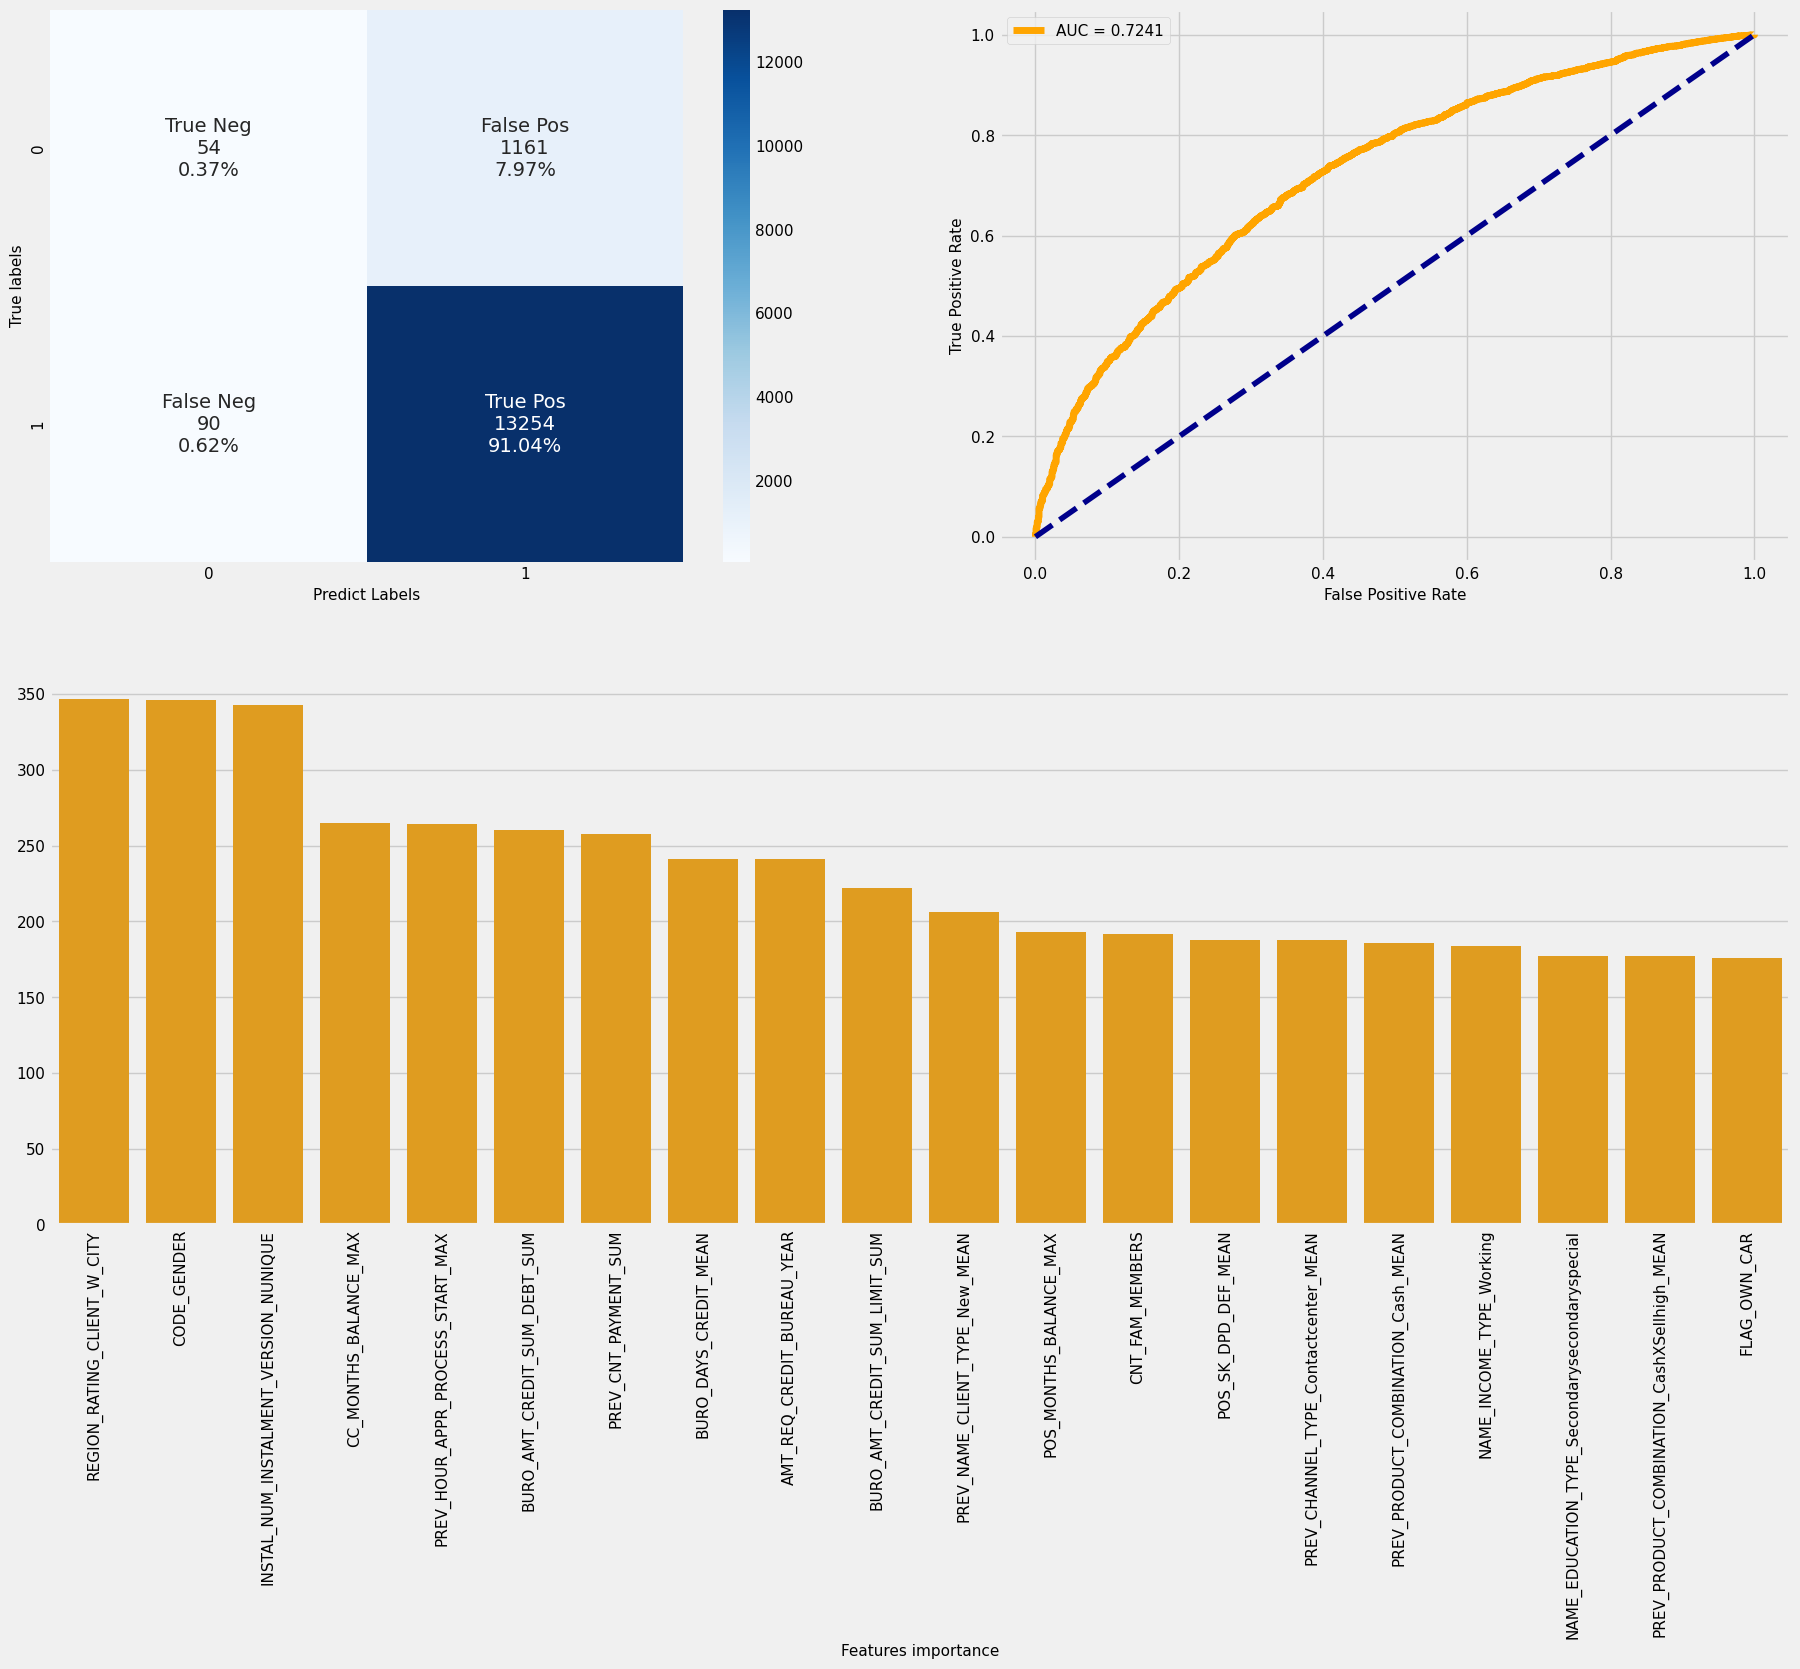

In [329]:
cf_matrix_roc_auc(best_lgbm, y_test_selected, best_lgbm.predict(X_test_selected), best_lgbm.predict_proba(X_test_selected)[:,1],
                  input_data = X_data, feature_importances=True, seuil = None)

In [330]:
metric_banking_1(y_test_selected,best_lgbm.predict(X_test_selected))

11700.006744604316

In [331]:
#X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
#y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
roc_auc = roc_auc_score(y_test_selected, best_lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.724145


In [332]:
cost_false(best_lgbm, y_test_selected, X_test_selected)

False Pos: 7.97%
False Neg: 0.62%


(0.07974448794560066, 0.006181743251596951)

In [333]:
joblib.dump(best_lgbm, 'best_lgbm.joblib')

['best_lgbm.joblib']

### 2e métrique:

In [334]:
# Définir l'espace des hyperparamètres à explorer
seed = 42
space = {
    'num_boost_round': hp.quniform('num_boost_round', 50, 200, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 100, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

# Définir la fonction objectif à minimiser

def objective_2(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'num_boost_round': int(params['num_boost_round']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        #'device':'gpu'
        }
    
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    
    
    # Cross-validation pour estimer les performances du modèle
    scores = cross_val_score(model, X_train_selected, y_train_selected, cv=cv, 
                             
                             scoring=credit_score_2
                             
                            )
    
    # Calcul de la moyenne des scores obtenus
    avg_score = scores.mean()
    
    return {'loss': - avg_score, 'status': 'ok'}  

# Créer une instance de Trials pour enregistrer les résultats de chaque essai
trials = Trials()

# Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
best_2 = fmin(fn=objective_2, space=space, algo=tpe.suggest, max_evals=40,  # Nombre d'essais d'hyperparamètres à effectuer
    trials=trials
)

[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
  0%|                                                                           | 0/40 [00:00<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
  0%|                                                                           | 0/40 [00:01<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
  0%|                                                                           | 0/40 [00:03<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
  0%|                                                                           | 0/40 [00:04<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
  0%|                                                                           | 0/40 [00:06<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
  2%|█▏                                               | 1/40 [00:07<05:00,  7.71s/trial, best loss: 0.4549348447974085]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
  2%|█▏                                               | 1/40 [00:08<05:00,  7.71s/trial, best loss: 0.4549348447974085]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
  2%|█▏                                               | 1/40 [00:09<05:00,  7.71s/trial, best loss: 0.4549348447974085]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
  2%|█▏                                               | 1/40 [00:10<05:00,  7.71s/trial, best loss: 0.4549348447974085]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
  2%|█▏                                               | 1/40 [00:12<05:00,  7.71s/trial, best loss: 0.4549348447974085]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
  5%|██▍                                             | 2/40 [00:13<04:01,  6.35s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
  5%|██▍                                             | 2/40 [00:15<04:01,  6.35s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
  5%|██▍                                             | 2/40 [00:18<04:01,  6.35s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
  5%|██▍                                             | 2/40 [00:22<04:01,  6.35s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
  5%|██▍                                             | 2/40 [00:25<04:01,  6.35s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
  8%|███▌                                            | 3/40 [00:29<06:36, 10.71s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
  8%|███▌                                            | 3/40 [00:31<06:36, 10.71s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
  8%|███▌                                            | 3/40 [00:33<06:36, 10.71s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
  8%|███▌                                            | 3/40 [00:36<06:36, 10.71s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
  8%|███▌                                            | 3/40 [00:38<06:36, 10.71s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 10%|████▊                                           | 4/40 [00:41<06:45, 11.26s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 10%|████▊                                           | 4/40 [00:44<06:45, 11.26s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 10%|████▊                                           | 4/40 [00:48<06:45, 11.26s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 10%|████▊                                           | 4/40 [00:51<06:45, 11.26s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=193, num_boost_round=193 will be ignored. Current value: num_iterations=193 
 10%|████▊                                           | 4/40 [00:55<06:45, 11.26s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 12%|██████                                          | 5/40 [00:59<08:01, 13.77s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 12%|██████                                          | 5/40 [01:01<08:01, 13.77s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 12%|██████                                          | 5/40 [01:02<08:01, 13.77s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 12%|██████                                          | 5/40 [01:04<08:01, 13.77s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=130, num_boost_round=130 will be ignored. Current value: num_iterations=130 
 12%|██████                                          | 5/40 [01:06<08:01, 13.77s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 15%|███████▏                                        | 6/40 [01:07<06:44, 11.91s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 15%|███████▏                                        | 6/40 [01:09<06:44, 11.91s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 15%|███████▏                                        | 6/40 [01:12<06:44, 11.91s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 15%|███████▏                                        | 6/40 [01:14<06:44, 11.91s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 15%|███████▏                                        | 6/40 [01:16<06:44, 11.91s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=57, num_boost_round=57 will be ignored. Current value: num_iterations=57    
 18%|████████▍                                       | 7/40 [01:18<06:25, 11.69s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=57, num_boost_round=57 will be ignored. Current value: num_iterations=57    
 18%|████████▍                                       | 7/40 [01:20<06:25, 11.69s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=57, num_boost_round=57 will be ignored. Current value: num_iterations=57    
 18%|████████▍                                       | 7/40 [01:21<06:25, 11.69s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=57, num_boost_round=57 will be ignored. Current value: num_iterations=57    
 18%|████████▍                                       | 7/40 [01:22<06:25, 11.69s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=57, num_boost_round=57 will be ignored. Current value: num_iterations=57    
 18%|████████▍                                       | 7/40 [01:23<06:25, 11.69s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 20%|█████████▌                                      | 8/40 [01:25<05:19,  9.97s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 20%|█████████▌                                      | 8/40 [01:27<05:19,  9.97s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 20%|█████████▌                                      | 8/40 [01:30<05:19,  9.97s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 20%|█████████▌                                      | 8/40 [01:32<05:19,  9.97s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=179, num_boost_round=179 will be ignored. Current value: num_iterations=179 
 20%|█████████▌                                      | 8/40 [01:34<05:19,  9.97s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=124, num_boost_round=124 will be ignored. Current value: num_iterations=124 
 22%|██████████▊                                     | 9/40 [01:37<05:29, 10.63s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=124, num_boost_round=124 will be ignored. Current value: num_iterations=124 
 22%|██████████▊                                     | 9/40 [01:39<05:29, 10.63s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=124, num_boost_round=124 will be ignored. Current value: num_iterations=124 
 22%|██████████▊                                     | 9/40 [01:41<05:29, 10.63s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=124, num_boost_round=124 will be ignored. Current value: num_iterations=124 
 22%|██████████▊                                     | 9/40 [01:44<05:29, 10.63s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=124, num_boost_round=124 will be ignored. Current value: num_iterations=124 
 22%|██████████▊                                     | 9/40 [01:46<05:29, 10.63s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=93, num_boost_round=93 will be ignored. Current value: num_iterations=93    
 25%|███████████▊                                   | 10/40 [01:48<05:25, 10.85s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=93, num_boost_round=93 will be ignored. Current value: num_iterations=93    
 25%|███████████▊                                   | 10/40 [01:50<05:25, 10.85s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=93, num_boost_round=93 will be ignored. Current value: num_iterations=93    
 25%|███████████▊                                   | 10/40 [01:52<05:25, 10.85s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=93, num_boost_round=93 will be ignored. Current value: num_iterations=93    
 25%|███████████▊                                   | 10/40 [01:54<05:25, 10.85s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=93, num_boost_round=93 will be ignored. Current value: num_iterations=93    
 25%|███████████▊                                   | 10/40 [01:56<05:25, 10.85s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 28%|████████████▉                                  | 11/40 [01:58<05:05, 10.54s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 28%|████████████▉                                  | 11/40 [02:01<05:05, 10.54s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 28%|████████████▉                                  | 11/40 [02:03<05:05, 10.54s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 28%|████████████▉                                  | 11/40 [02:06<05:05, 10.54s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=189, num_boost_round=189 will be ignored. Current value: num_iterations=189 
 28%|████████████▉                                  | 11/40 [02:08<05:05, 10.54s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 30%|██████████████                                 | 12/40 [02:11<05:16, 11.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 30%|██████████████                                 | 12/40 [02:13<05:16, 11.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 30%|██████████████                                 | 12/40 [02:15<05:16, 11.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 30%|██████████████                                 | 12/40 [02:18<05:16, 11.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=133, num_boost_round=133 will be ignored. Current value: num_iterations=133 
 30%|██████████████                                 | 12/40 [02:20<05:16, 11.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 32%|███████████████▎                               | 13/40 [02:22<05:03, 11.24s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 32%|███████████████▎                               | 13/40 [02:24<05:03, 11.24s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 32%|███████████████▎                               | 13/40 [02:26<05:03, 11.24s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 32%|███████████████▎                               | 13/40 [02:28<05:03, 11.24s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 32%|███████████████▎                               | 13/40 [02:29<05:03, 11.24s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=106, num_boost_round=106 will be ignored. Current value: num_iterations=106 
 35%|████████████████▍                              | 14/40 [02:32<04:42, 10.86s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=106, num_boost_round=106 will be ignored. Current value: num_iterations=106 
 35%|████████████████▍                              | 14/40 [02:35<04:42, 10.86s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=106, num_boost_round=106 will be ignored. Current value: num_iterations=106 
 35%|████████████████▍                              | 14/40 [02:37<04:42, 10.86s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=106, num_boost_round=106 will be ignored. Current value: num_iterations=106 
 35%|████████████████▍                              | 14/40 [02:39<04:42, 10.86s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=106, num_boost_round=106 will be ignored. Current value: num_iterations=106 
 35%|████████████████▍                              | 14/40 [02:41<04:42, 10.86s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=90, num_boost_round=90 will be ignored. Current value: num_iterations=90    
 38%|█████████████████▋                             | 15/40 [02:43<04:34, 10.99s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=90, num_boost_round=90 will be ignored. Current value: num_iterations=90    
 38%|█████████████████▋                             | 15/40 [02:45<04:34, 10.99s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=90, num_boost_round=90 will be ignored. Current value: num_iterations=90    
 38%|█████████████████▋                             | 15/40 [02:47<04:34, 10.99s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=90, num_boost_round=90 will be ignored. Current value: num_iterations=90    
 38%|█████████████████▋                             | 15/40 [02:48<04:34, 10.99s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=90, num_boost_round=90 will be ignored. Current value: num_iterations=90    
 38%|█████████████████▋                             | 15/40 [02:50<04:34, 10.99s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 40%|██████████████████▊                            | 16/40 [02:52<04:04, 10.17s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 40%|██████████████████▊                            | 16/40 [02:54<04:04, 10.17s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 40%|██████████████████▊                            | 16/40 [02:55<04:04, 10.17s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 40%|██████████████████▊                            | 16/40 [02:57<04:04, 10.17s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=97, num_boost_round=97 will be ignored. Current value: num_iterations=97    
 40%|██████████████████▊                            | 16/40 [02:59<04:04, 10.17s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=78, num_boost_round=78 will be ignored. Current value: num_iterations=78    
 42%|███████████████████▉                           | 17/40 [03:01<03:46,  9.84s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=78, num_boost_round=78 will be ignored. Current value: num_iterations=78    
 42%|███████████████████▉                           | 17/40 [03:03<03:46,  9.84s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=78, num_boost_round=78 will be ignored. Current value: num_iterations=78    
 42%|███████████████████▉                           | 17/40 [03:04<03:46,  9.84s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=78, num_boost_round=78 will be ignored. Current value: num_iterations=78    
 42%|███████████████████▉                           | 17/40 [03:07<03:46,  9.84s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=78, num_boost_round=78 will be ignored. Current value: num_iterations=78    
 42%|███████████████████▉                           | 17/40 [03:08<03:46,  9.84s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 45%|█████████████████████▏                         | 18/40 [03:10<03:33,  9.72s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 45%|█████████████████████▏                         | 18/40 [03:12<03:33,  9.72s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 45%|█████████████████████▏                         | 18/40 [03:14<03:33,  9.72s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 45%|█████████████████████▏                         | 18/40 [03:16<03:33,  9.72s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=187, num_boost_round=187 will be ignored. Current value: num_iterations=187 
 45%|█████████████████████▏                         | 18/40 [03:18<03:33,  9.72s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76    
 48%|██████████████████████▎                        | 19/40 [03:20<03:21,  9.61s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76    
 48%|██████████████████████▎                        | 19/40 [03:21<03:21,  9.61s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76    
 48%|██████████████████████▎                        | 19/40 [03:23<03:21,  9.61s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76    
 48%|██████████████████████▎                        | 19/40 [03:25<03:21,  9.61s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76    
 48%|██████████████████████▎                        | 19/40 [03:26<03:21,  9.61s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=52, num_boost_round=52 will be ignored. Current value: num_iterations=52    
 50%|███████████████████████▌                       | 20/40 [03:28<03:05,  9.27s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=52, num_boost_round=52 will be ignored. Current value: num_iterations=52    
 50%|███████████████████████▌                       | 20/40 [03:29<03:05,  9.27s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=52, num_boost_round=52 will be ignored. Current value: num_iterations=52    
 50%|███████████████████████▌                       | 20/40 [03:30<03:05,  9.27s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=52, num_boost_round=52 will be ignored. Current value: num_iterations=52    
 50%|███████████████████████▌                       | 20/40 [03:32<03:05,  9.27s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=52, num_boost_round=52 will be ignored. Current value: num_iterations=52    
 50%|███████████████████████▌                       | 20/40 [03:33<03:05,  9.27s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 52%|████████████████████████▋                      | 21/40 [03:34<02:37,  8.31s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 52%|████████████████████████▋                      | 21/40 [03:36<02:37,  8.31s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 52%|████████████████████████▋                      | 21/40 [03:38<02:37,  8.31s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 52%|████████████████████████▋                      | 21/40 [03:39<02:37,  8.31s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=146, num_boost_round=146 will be ignored. Current value: num_iterations=146 
 52%|████████████████████████▋                      | 21/40 [03:41<02:37,  8.31s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=110, num_boost_round=110 will be ignored. Current value: num_iterations=110 
 55%|█████████████████████████▊                     | 22/40 [03:43<02:31,  8.43s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=110, num_boost_round=110 will be ignored. Current value: num_iterations=110 
 55%|█████████████████████████▊                     | 22/40 [03:44<02:31,  8.43s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=110, num_boost_round=110 will be ignored. Current value: num_iterations=110 
 55%|█████████████████████████▊                     | 22/40 [03:46<02:31,  8.43s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=110, num_boost_round=110 will be ignored. Current value: num_iterations=110 
 55%|█████████████████████████▊                     | 22/40 [03:47<02:31,  8.43s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=110, num_boost_round=110 will be ignored. Current value: num_iterations=110 
 55%|█████████████████████████▊                     | 22/40 [03:49<02:31,  8.43s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=154, num_boost_round=154 will be ignored. Current value: num_iterations=154 
 57%|███████████████████████████                    | 23/40 [03:51<02:23,  8.44s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=154, num_boost_round=154 will be ignored. Current value: num_iterations=154 
 57%|███████████████████████████                    | 23/40 [03:54<02:23,  8.44s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=154, num_boost_round=154 will be ignored. Current value: num_iterations=154 
 57%|███████████████████████████                    | 23/40 [03:56<02:23,  8.44s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=154, num_boost_round=154 will be ignored. Current value: num_iterations=154 
 57%|███████████████████████████                    | 23/40 [03:58<02:23,  8.44s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=154, num_boost_round=154 will be ignored. Current value: num_iterations=154 
 57%|███████████████████████████                    | 23/40 [04:00<02:23,  8.44s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=65, num_boost_round=65 will be ignored. Current value: num_iterations=65    
 60%|████████████████████████████▏                  | 24/40 [04:02<02:27,  9.23s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=65, num_boost_round=65 will be ignored. Current value: num_iterations=65    
 60%|████████████████████████████▏                  | 24/40 [04:04<02:27,  9.23s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=65, num_boost_round=65 will be ignored. Current value: num_iterations=65    
 60%|████████████████████████████▏                  | 24/40 [04:05<02:27,  9.23s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=65, num_boost_round=65 will be ignored. Current value: num_iterations=65    
 60%|████████████████████████████▏                  | 24/40 [04:06<02:27,  9.23s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=65, num_boost_round=65 will be ignored. Current value: num_iterations=65    
 60%|████████████████████████████▏                  | 24/40 [04:07<02:27,  9.23s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 62%|█████████████████████████████▍                 | 25/40 [04:08<02:04,  8.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 62%|█████████████████████████████▍                 | 25/40 [04:10<02:04,  8.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 62%|█████████████████████████████▍                 | 25/40 [04:12<02:04,  8.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 62%|█████████████████████████████▍                 | 25/40 [04:14<02:04,  8.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=139, num_boost_round=139 will be ignored. Current value: num_iterations=139 
 62%|█████████████████████████████▍                 | 25/40 [04:16<02:04,  8.30s/trial, best loss: 0.44860285447569187]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=143, num_boost_round=143 will be ignored. Current value: num_iterations=143 
 65%|██████████████████████████████▌                | 26/40 [04:18<02:02,  8.76s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=143, num_boost_round=143 will be ignored. Current value: num_iterations=143 
 65%|██████████████████████████████▌                | 26/40 [04:20<02:02,  8.76s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=143, num_boost_round=143 will be ignored. Current value: num_iterations=143 
 65%|██████████████████████████████▌                | 26/40 [04:22<02:02,  8.76s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=143, num_boost_round=143 will be ignored. Current value: num_iterations=143 
 65%|██████████████████████████████▌                | 26/40 [04:24<02:02,  8.76s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=143, num_boost_round=143 will be ignored. Current value: num_iterations=143 
 65%|██████████████████████████████▌                | 26/40 [04:26<02:02,  8.76s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 68%|███████████████████████████████▋               | 27/40 [04:28<01:57,  9.03s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 68%|███████████████████████████████▋               | 27/40 [04:30<01:57,  9.03s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 68%|███████████████████████████████▋               | 27/40 [04:32<01:57,  9.03s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 68%|███████████████████████████████▋               | 27/40 [04:35<01:57,  9.03s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=167, num_boost_round=167 will be ignored. Current value: num_iterations=167 
 68%|███████████████████████████████▋               | 27/40 [04:37<01:57,  9.03s/trial, best loss: 0.44837564223548565]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
 70%|█████████████████████████████████▌              | 28/40 [04:39<01:55,  9.67s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
 70%|█████████████████████████████████▌              | 28/40 [04:41<01:55,  9.67s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
 70%|█████████████████████████████████▌              | 28/40 [04:44<01:55,  9.67s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
 70%|█████████████████████████████████▌              | 28/40 [04:46<01:55,  9.67s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=173, num_boost_round=173 will be ignored. Current value: num_iterations=173 
 70%|█████████████████████████████████▌              | 28/40 [04:48<01:55,  9.67s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 72%|██████████████████████████████████▊             | 29/40 [04:50<01:51, 10.15s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 72%|██████████████████████████████████▊             | 29/40 [04:53<01:51, 10.15s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 72%|██████████████████████████████████▊             | 29/40 [04:55<01:51, 10.15s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 72%|██████████████████████████████████▊             | 29/40 [04:57<01:51, 10.15s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=166, num_boost_round=166 will be ignored. Current value: num_iterations=166 
 72%|██████████████████████████████████▊             | 29/40 [04:59<01:51, 10.15s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 75%|████████████████████████████████████            | 30/40 [05:01<01:43, 10.31s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 75%|████████████████████████████████████            | 30/40 [05:03<01:43, 10.31s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 75%|████████████████████████████████████            | 30/40 [05:06<01:43, 10.31s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 75%|████████████████████████████████████            | 30/40 [05:08<01:43, 10.31s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=163, num_boost_round=163 will be ignored. Current value: num_iterations=163 
 75%|████████████████████████████████████            | 30/40 [05:10<01:43, 10.31s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 78%|█████████████████████████████████████▏          | 31/40 [05:12<01:34, 10.53s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 78%|█████████████████████████████████████▏          | 31/40 [05:14<01:34, 10.53s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 78%|█████████████████████████████████████▏          | 31/40 [05:17<01:34, 10.53s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 78%|█████████████████████████████████████▏          | 31/40 [05:20<01:34, 10.53s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=174, num_boost_round=174 will be ignored. Current value: num_iterations=174 
 78%|█████████████████████████████████████▏          | 31/40 [05:22<01:34, 10.53s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 80%|██████████████████████████████████████▍         | 32/40 [05:26<01:31, 11.43s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 80%|██████████████████████████████████████▍         | 32/40 [05:28<01:31, 11.43s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 80%|██████████████████████████████████████▍         | 32/40 [05:30<01:31, 11.43s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 80%|██████████████████████████████████████▍         | 32/40 [05:32<01:31, 11.43s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=183, num_boost_round=183 will be ignored. Current value: num_iterations=183 
 80%|██████████████████████████████████████▍         | 32/40 [05:34<01:31, 11.43s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 82%|███████████████████████████████████████▌        | 33/40 [05:36<01:18, 11.17s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 82%|███████████████████████████████████████▌        | 33/40 [05:39<01:18, 11.17s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 82%|███████████████████████████████████████▌        | 33/40 [05:42<01:18, 11.17s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 82%|███████████████████████████████████████▌        | 33/40 [05:45<01:18, 11.17s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=171, num_boost_round=171 will be ignored. Current value: num_iterations=171 
 82%|███████████████████████████████████████▌        | 33/40 [05:47<01:18, 11.17s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 85%|████████████████████████████████████████▊       | 34/40 [05:50<01:12, 12.06s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 85%|████████████████████████████████████████▊       | 34/40 [05:53<01:12, 12.06s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 85%|████████████████████████████████████████▊       | 34/40 [05:56<01:12, 12.06s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 85%|████████████████████████████████████████▊       | 34/40 [05:58<01:12, 12.06s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194 
 85%|████████████████████████████████████████▊       | 34/40 [06:00<01:12, 12.06s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 88%|██████████████████████████████████████████      | 35/40 [06:03<01:00, 12.16s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 88%|██████████████████████████████████████████      | 35/40 [06:05<01:00, 12.16s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 88%|██████████████████████████████████████████      | 35/40 [06:07<01:00, 12.16s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 88%|██████████████████████████████████████████      | 35/40 [06:10<01:00, 12.16s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 88%|██████████████████████████████████████████      | 35/40 [06:12<01:00, 12.16s/trial, best loss: 0.4476162670923289]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 90%|███████████████████████████████████████████▏    | 36/40 [06:14<00:47, 11.95s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 90%|███████████████████████████████████████████▏    | 36/40 [06:16<00:47, 11.95s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 90%|███████████████████████████████████████████▏    | 36/40 [06:19<00:47, 11.95s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 90%|███████████████████████████████████████████▏    | 36/40 [06:22<00:47, 11.95s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 90%|███████████████████████████████████████████▏    | 36/40 [06:24<00:47, 11.95s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 92%|████████████████████████████████████████████▍   | 37/40 [06:26<00:35, 11.96s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 92%|████████████████████████████████████████████▍   | 37/40 [06:29<00:35, 11.96s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 92%|████████████████████████████████████████████▍   | 37/40 [06:31<00:35, 11.96s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 92%|████████████████████████████████████████████▍   | 37/40 [06:33<00:35, 11.96s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 92%|████████████████████████████████████████████▍   | 37/40 [06:35<00:35, 11.96s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 95%|█████████████████████████████████████████████▌  | 38/40 [06:38<00:23, 11.76s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 95%|█████████████████████████████████████████████▌  | 38/40 [06:42<00:23, 11.76s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 95%|█████████████████████████████████████████████▌  | 38/40 [06:45<00:23, 11.76s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 95%|█████████████████████████████████████████████▌  | 38/40 [06:49<00:23, 11.76s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=199, num_boost_round=199 will be ignored. Current value: num_iterations=199 
 95%|█████████████████████████████████████████████▌  | 38/40 [06:54<00:23, 11.76s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|██████████████████████████████████████████████▊ | 39/40 [06:58<00:14, 14.36s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|██████████████████████████████████████████████▊ | 39/40 [07:00<00:14, 14.36s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|██████████████████████████████████████████████▊ | 39/40 [07:02<00:14, 14.36s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|██████████████████████████████████████████████▊ | 39/40 [07:04<00:14, 14.36s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200 
 98%|██████████████████████████████████████████████▊ | 39/40 [07:07<00:14, 14.36s/trial, best loss: 0.4467276468604514]

Found `num_boost_round` in params. Will use it instead of argument



100%|████████████████████████████████████████████████| 40/40 [07:09<00:00, 10.73s/trial, best loss: 0.4467276468604514]


In [335]:
%%time
best_lgbm_2 = LGBMClassifier( #Fit a new model based on the best parameters
    num_boost_round = int(best_2['num_boost_round']),
    n_estimators=best_2['n_estimators'], 
    seed = 2023,
    boosting_type = 'gbdt',
    objective = 'binary',
    colsample_bytree= best_2['colsample_bytree'],
    learning_rate= best_2['learning_rate'],
    max_depth= int(best_2['max_depth']),
    num_leaves = int(best_2['num_leaves']),
    subsample= best_2['subsample'],
    reg_lambda= best_2['reg_lambda'])

best_lgbm_2.fit(X_train_selected, y_train_selected)

Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198
Wall time: 1.96 s


LGBMClassifier(colsample_bytree=0.7208511170024899,
               learning_rate=0.0010676004489444044, max_depth=3,
               n_estimators=300.0, num_boost_round=198, num_leaves=40,
               objective='binary', reg_lambda=14.09326956156637, seed=2023,
               subsample=0.6298066783528248)

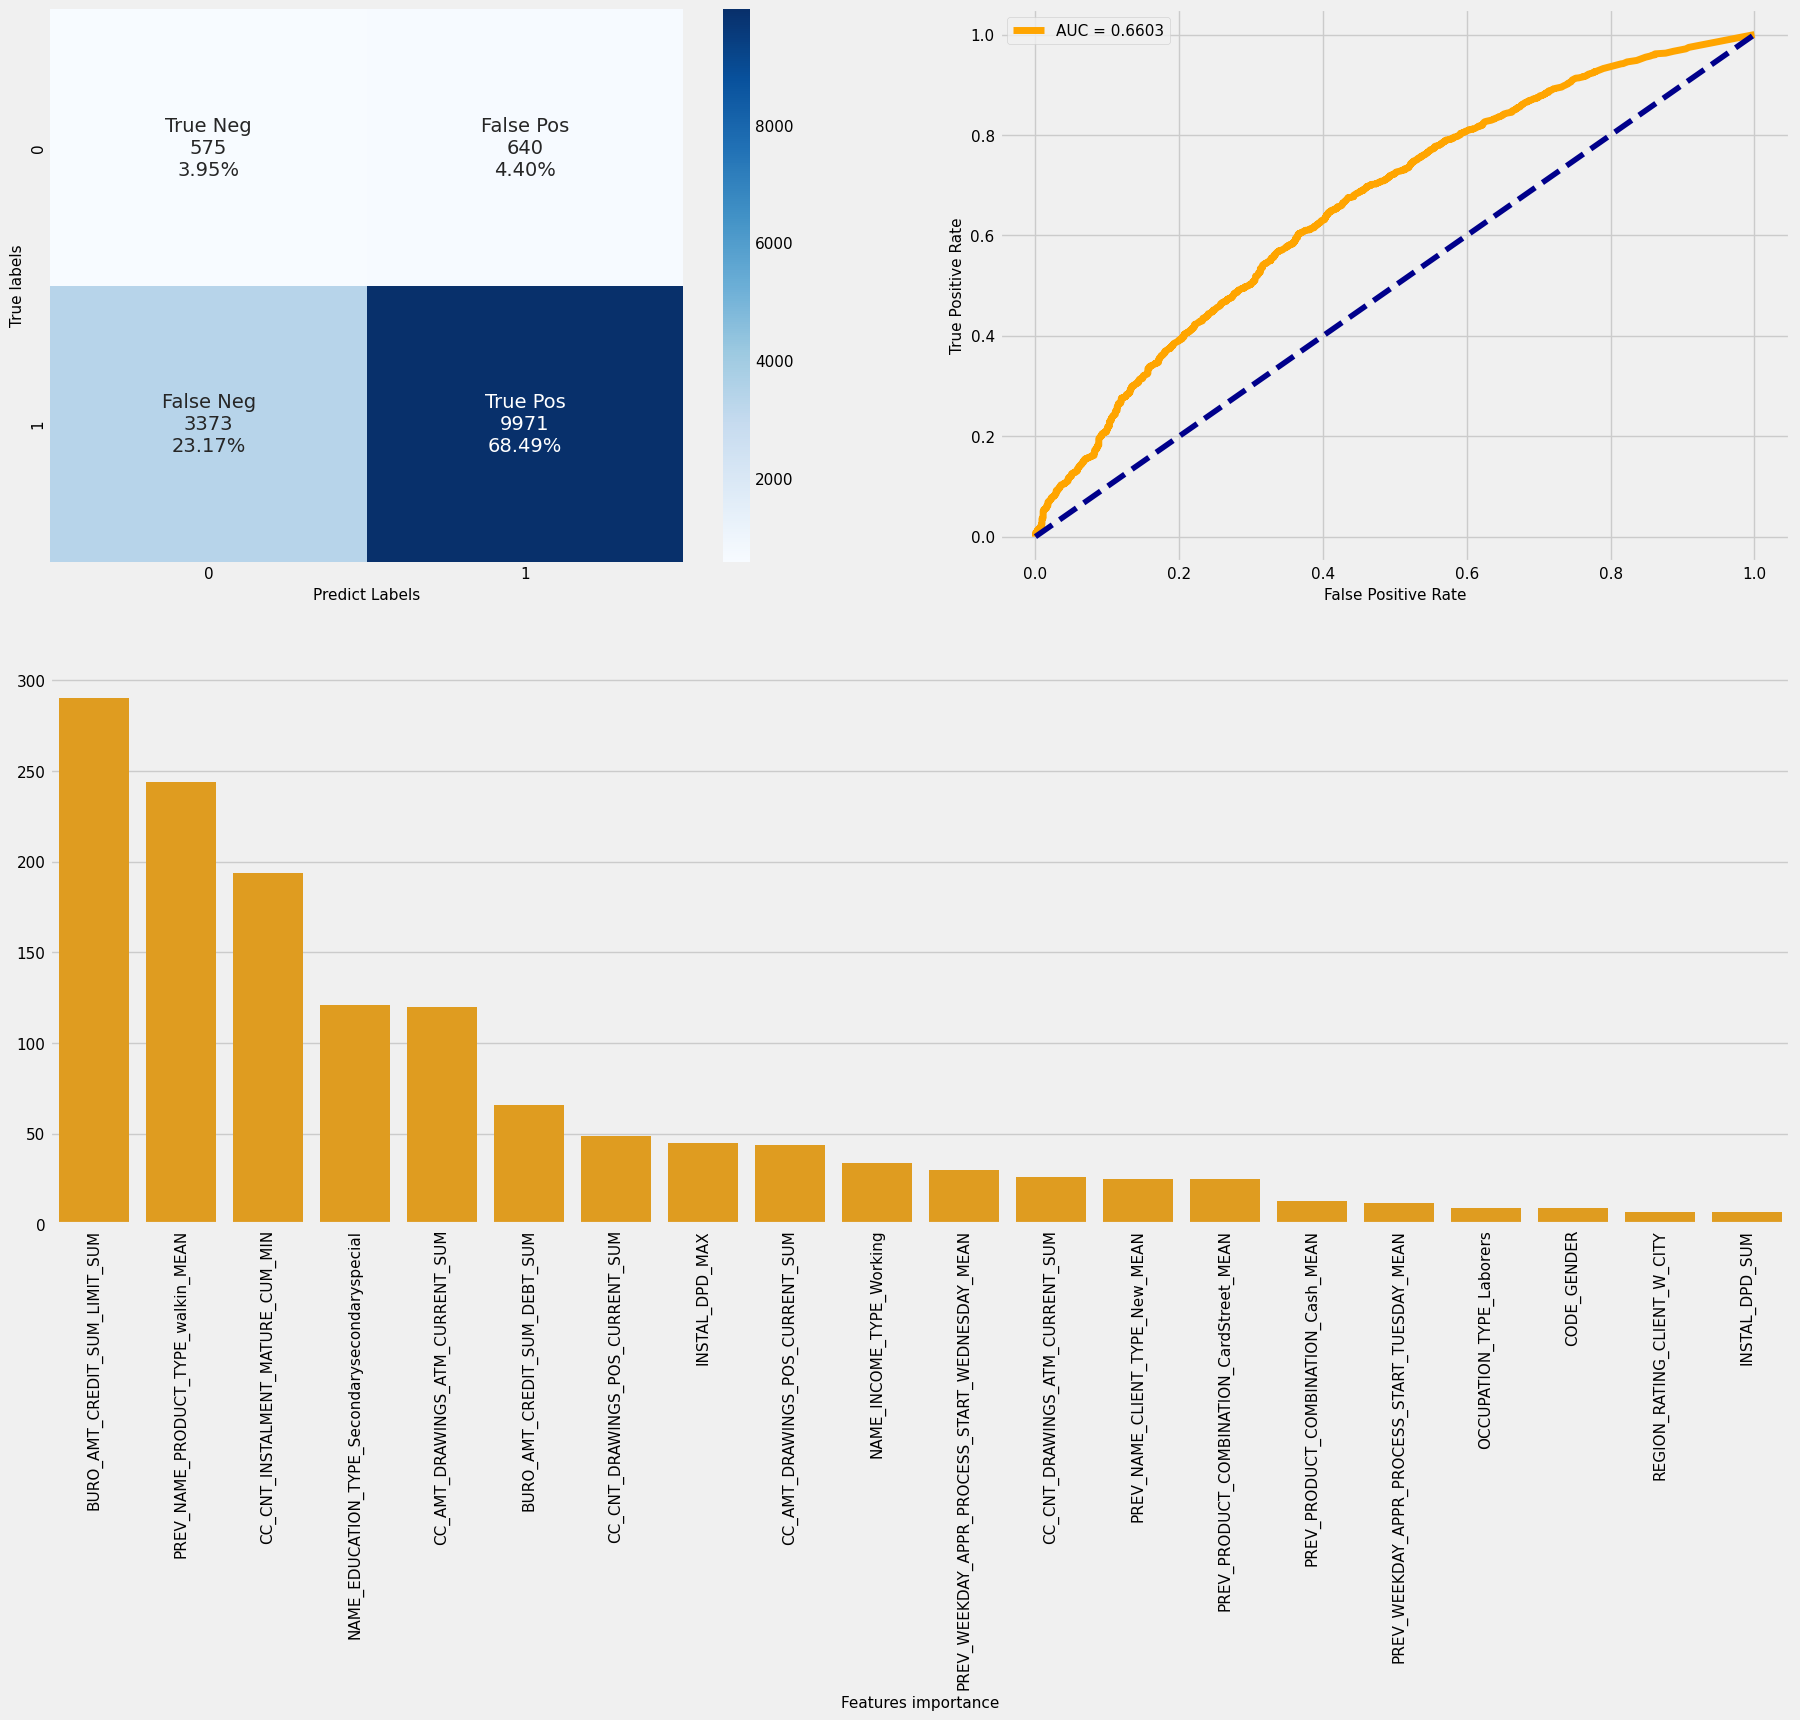

In [336]:
cf_matrix_roc_auc(best_lgbm_2, y_test_selected, best_lgbm_2.predict(X_test_selected), best_lgbm_2.predict_proba(X_test_selected)[:,1],
                  input_data = X_data, feature_importances=True, seuil = None)

In [337]:
metric_banking_2(y_test_selected,best_lgbm_2.predict(X_test_selected))

0.935367841285899

In [338]:
best_lgbm_2.predict(X_test_selected)

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [339]:
best_lgbm_2.predict_proba(X_test_selected)[:,1]

array([0.49527596, 0.53346099, 0.47489653, ..., 0.52499742, 0.51542843,
       0.54097265])

In [340]:
#X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
#y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
roc_auc = roc_auc_score(y_test_selected, best_lgbm_2.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.660290


In [341]:
cost_false(best_lgbm_2, y_test_selected, X_test_selected)

False Pos: 4.40%
False Neg: 23.17%


(0.0439590631224672, 0.23167799986262794)

On retiendra le 2e model (`best_lgbm_2`) car celui ci certes a un score AUC un peu moins bon que le premier (environ 0.66 contre 0.72) mais pénalise mieux les faux positifs (4.40% contre 8%). En plus il y a une bonne cohérence sur les features les plus infuluants. 

In [342]:
joblib.dump(best_lgbm_2, 'best_lgbm_2.joblib')

['best_lgbm_2.joblib']

Ajoutons notre "metric métier" dans la fonction "train_models":

In [343]:
joblib.dump(best_lgbm_2, 'final_model.joblib')
import joblib
final_model = joblib.load('final_model.joblib')

In [10]:
import pickle
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f, protocol=4)

In [8]:
with open('final_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [9]:
loaded_model

LGBMClassifier(colsample_bytree=0.7208511170024899,
               learning_rate=0.0010676004489444044, max_depth=3,
               n_estimators=300.0, num_boost_round=198, num_leaves=40,
               objective='binary', reg_lambda=14.09326956156637, seed=2023,
               subsample=0.6298066783528248)

In [344]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'metric_banking': metric_banking_2(y_test, model.predict(X_test))
      }
          
    return output

In [345]:
train_models(final_model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)

Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198


{'AUC': 0.6602903171290129,
 'Accuracy': 0.7243629370149048,
 'Precision': 0.9396852323060975,
 'Recall': 0.7472272182254197,
 'F1': 0.832477562095596,
 'metric_banking': 0.935367841285899}

----------------------------------------------------

### Optimisation des hyperparamètres avec GridSearchCV:

# ---------------------------------------------------------------------------------------------------------------

In [ ]:
#Début pour GridSearchCV que je met en commantaire car après son exploitation on a constaté que ça prend beaucoup de temps\
# et le résultat n'est pas meilleur que HyperOpt

On va utiliser GridSearchCV pour optimiser les paramèttres et comparer le modèle pa rapport à celui optimisé par hyperopt.

On pourrait utiliser un pipeline dans cette partie mais vu que l'on ait déjà enregistré des données pré-traitées on va plutot les utiliser pour gagner du temps:

In [ ]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# #Parameter space
# param_grid = {
#     'metric': ['credit_score_1', 'credit_score_2'],
#     'num_boost_round': np.arange( 70, 200, 30),
#      'n_estimators': np.arange(100, 300, 50),
#      'learning_rate': np.arange(0.005, 1, 0.5),
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#      #'max_depth': np.arange(3, 7, 1),
#      'num_leaves': np.arange(20, 100, 10),
#      #'subsample': np.arange(0.50, 1.0, 0.05),
#      #'colsample_bytree': np.arange(0.50, 1.0, 0.05),
#      #'reg_lambda': np.arange(1, 20, 0.5)
#     }

# cv = StratifiedKFold(5)
# # Effectuer la recherche en grille:
# grid = GridSearchCV(LGBMClassifier(), param_grid=param_grid, cv=cv)

In [ ]:
# %%time
# grid.fit(X_val_selected, y_val_selected)

In [ ]:
# # Afficher les meilleurs paramètres et la meilleure performance
# print("Meilleurs paramètres: {}".format(grid.best_params_))
# print("Meilleure performance: {:.2f}".format(grid.best_score_))

In [ ]:
# best_lgbm_gridSearch = grid.best_estimator_
# best_lgbm_params_gridSearch = grid.best_params_

# #sauvegarde
# joblib.dump(best_lgbm_gridSearch, 'best_lgbm_gridSearch.joblib')
# joblib.dump(best_lgbm_params_gridSearch, 'best_lgbm_params_gridSearch.joblib')

In [ ]:
# #chargement du meilleur model d'après gridSearchCV
# #import joblib
# best_lgbm_gridSearch = joblib.load("best_lgbm_gridSearch.joblib")
# best_lgbm_params_gridSearch = joblib.load("best_lgbm_params_gridSearch.joblib")

In [ ]:
# cost_false(best_lgbm_gridSearch, y_test_selected, X_test_selected)

In [ ]:
# best_lgbm_gridSearch_params_1 = grid.best_params_
# best_lgbm_gridSearch_1 = grid.best_estimator_
# joblib.dump(best_lgbm_gridSearch_1, 'notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib')
# joblib.dump(best_lgbm_gridSearch_params_1, 'notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_params_1.joblib')

In [ ]:
# best_lgbm_gridSearch = joblib.load("notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib")

# cf_matrix_roc_auc(best_lgbm_gridSearch, y_test_selected, best_lgbm_gridSearch.predict(X_test_selected), best_lgbm_gridSearch.predict_proba(X_test_selected)[:,1], 
#                   input_data = X_data, feature_importances=True, seuil = None)

# ---------------------------------------------------------------------------------------------------------------

### Comparaison du model optimisé par GridSearchCV avec celui optimisé par HyperOpt:

In [ ]:
#best_lgbm_gridSearch = joblib.load("notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib")

In [ ]:
# roc_auc = roc_auc_score(y_test_selected, best_lgbm_gridSearch.predict_proba(X_test_selected)[:,1])
# print("Avec GridSearchCV:")
# print('AUC : %0.4f' %roc_auc)
# print(classification_report(y_test_selected, best_lgbm_gridSearch.predict(X_test_selected)))

In [346]:
roc_auc = roc_auc_score(y_test_selected, final_model.predict_proba(X_test_selected)[:,1])
print("Avec HyperOpt:")
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test_selected, final_model.predict(X_test_selected)))

Avec HyperOpt:
AUC : 0.6603
              precision    recall  f1-score   support

           0       0.15      0.47      0.22      1215
           1       0.94      0.75      0.83     13344

    accuracy                           0.72     14559
   macro avg       0.54      0.61      0.53     14559
weighted avg       0.87      0.72      0.78     14559



On obtient un meilleur score avec HypertOpt en plus ce dernier donne le résultat en moins de temps que GridSearchCV. 

### Recherche du seuil (threshold):

Une sensibilité (recall) élevée est généralement souhaitable dans le contexte du scoring de crédit, car cela signifie que le modèle identifie efficacement les clients présentant un risque élevé.

In [3]:

X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
X_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_train_selected.joblib')
y_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_train_selected.joblib')

#### Recherche: 

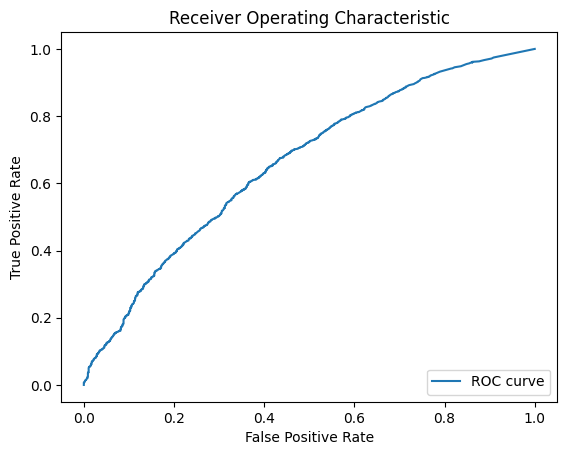

Seuil optimal: 0.517977460410714


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_selected, y_pred_proba)

# Calcul de la distance au coin supérieur gauche pour trouver le seuil optimal
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[optimal_threshold_index]

# Tracer la courbe ROC
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("Seuil optimal:", optimal_threshold)

In [5]:
print("On prendrait un seuil =", optimal_threshold, " pour accorder ou non le credit à un client")

On prendrait un seuil = 0.517977460410714  pour accorder ou non le credit à un client


In [350]:
seuil = optimal_threshold

## Feature importances avec LIME:

In [351]:
features_names = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns

Intercept 0.4820883260962718
Prediction_local [0.45911458]
Right: 0.4952759603169029


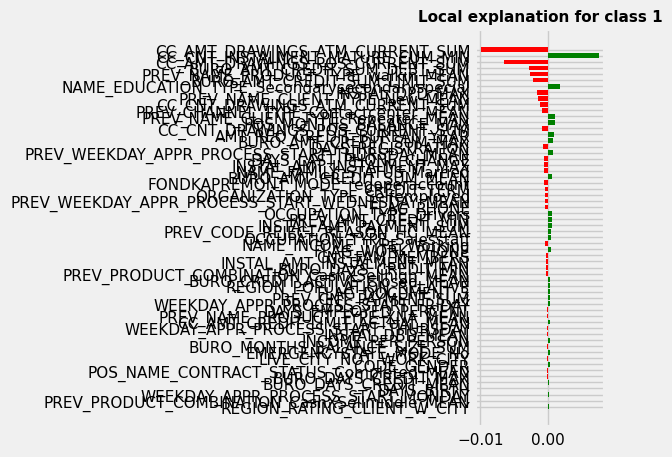

In [352]:
import lime
import lime.lime_tabular
best_model = joblib.load("final_model.joblib")
features = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns
#Explain samples in test set
X_explain = X_test_selected
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_selected,
                                                   feature_names=features.values,
                                                   discretize_continuous=False,
                                                   class_names=["0", "1"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=seed)

#Explaining first subject in test set using all 60 features
exp = explainer.explain_instance(X_explain[0,:],best_model.predict_proba, 
                                 num_features=60)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

## Feature importances avec SHAP:

In [ ]:
# import joblib
# print(joblib.__version__)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


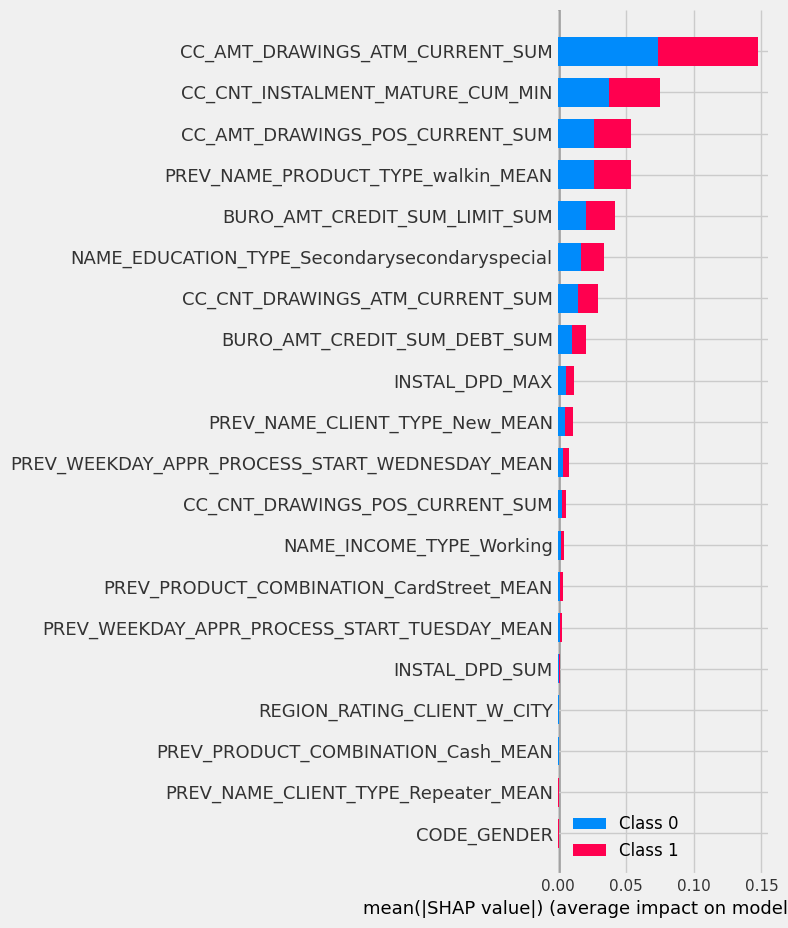

In [353]:
import shap
import lightgbm as lgb
features_names = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns

# calculer les valeurs SHAP pour toutes les observations
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

# afficher les explications pour chaque observation
shap.summary_plot(shap_values, X_test_selected, feature_names=features_names)

-----------------------------------------

### Mise en place Mlflow:

In [354]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib
import mlflow
#from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [355]:
#import joblib
best_lgbmc = joblib.load("final_model.joblib") # enregistrer dans le repertoire notbooks_P7
best_parameters = joblib.load("best_lgbm_params.joblib")

X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
X_train_selected = joblib.load("notebooks_P7/Data_projet7/new_data/X_train_selected.joblib")


y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
y_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_train_selected.joblib')

In [356]:
seuil = optimal_threshold
def eval_metrics(y_true, y_pred_prob, seuil = seuil):
    "y_pred_prob c'est la probabilité qu'un client soit solvable"
    auc_score = roc_auc_score(y_true, y_pred_prob)
    pred = np.where(y_pred_prob > seuil, 1, 0)
    score = metric_banking_2(y_true, pred)
    f1score = f1_score(y_true, pred, average='weighted')
    return auc_score, score, f1score

In [358]:
y_pred_prob = final_model.predict_proba(X_test_selected)[:,1]
eval_metrics(y_test_selected, y_pred_prob, seuil = seuil)

(0.6602903171290129, 0.90530652401156, 0.6934016700870019)

In [359]:
seuil_proba = optimal_threshold
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion matrix", cmap=plt.cm.Blues, normalize=True):
    """
    This function plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        xlabel="Ground truth label",
        ylabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30,
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations for both numbers and percentages.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = format(cm[i, j], fmt)
            if normalize:
                text += f" ({cm[i, j]*100:.1f}%)"
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

In [360]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def create_roc_plot(fpr, tpr, model_lgbmc):
    """
    Create ROC curve.
    :param fpr: false positive.
    :param tpr: true positive.
    :return: returns a tuple of plt, fig, ax
    """
    # Calculate AUC score
    probs_lgbmc = model_lgbmc.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test_selected, probs_lgbmc)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend()
    
    
    
    return plt, fig, ax

### Expérience 1: LGBMClassifier - modèle optimisé sur le score metier:

In [ ]:
#Si un moment mlflow ne se lance pas, il faut essayer de redémarer le serveur mlflow
#avec la commande suivante sur un terminal anaconda prompt par exemple:
#activer d'abord l'environement:    conda activate monenvprojet
#se placer dans le repertoir et executer la commande suivante: mlflow server --host 0.0.0.0 --port 5000

[LightGBM] [Warning] num_iterations is set=178, num_boost_round=178 will be ignored. Current value: num_iterations=178 
  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=178, num_boost_round=178 will be ignored. Current value: num_iterations=178 
  0%|                                                                           | 0/30 [00:01<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=178, num_boost_round=178 will be ignored. Current value: num_iterations=178 
  0%|                                                                           | 0/30 [00:03<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=178, num_boost_round=178 will be ignored. Current value: num_iterations=178 
  0%|                                                                           | 0/30 [00:05<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=178, num_boost_round=178 will be ignored. Current value: num_iterations=178 
  0%|                                                                           | 0/30 [00:06<?, ?trial/s, best loss=?]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=140, num_boost_round=140 will be ignored. Current value: num_iterations=140 
  3%|█▌                                              | 1/30 [00:08<04:03,  8.40s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=140, num_boost_round=140 will be ignored. Current value: num_iterations=140 
  3%|█▌                                              | 1/30 [00:09<04:03,  8.40s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=140, num_boost_round=140 will be ignored. Current value: num_iterations=140 
  3%|█▌                                              | 1/30 [00:11<04:03,  8.40s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=140, num_boost_round=140 will be ignored. Current value: num_iterations=140 
  3%|█▌                                              | 1/30 [00:12<04:03,  8.40s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=140, num_boost_round=140 will be ignored. Current value: num_iterations=140 
  3%|█▌                                              | 1/30 [00:13<04:03,  8.40s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
  7%|███▏                                            | 2/30 [00:15<03:30,  7.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
  7%|███▏                                            | 2/30 [00:17<03:30,  7.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
  7%|███▏                                            | 2/30 [00:19<03:30,  7.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
  7%|███▏                                            | 2/30 [00:21<03:30,  7.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=131, num_boost_round=131 will be ignored. Current value: num_iterations=131 
  7%|███▏                                            | 2/30 [00:23<03:30,  7.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 10%|████▊                                           | 3/30 [00:25<03:57,  8.81s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 10%|████▊                                           | 3/30 [00:28<03:57,  8.81s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 10%|████▊                                           | 3/30 [00:30<03:57,  8.81s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 10%|████▊                                           | 3/30 [00:33<03:57,  8.81s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=157, num_boost_round=157 will be ignored. Current value: num_iterations=157 
 10%|████▊                                           | 3/30 [00:35<03:57,  8.81s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
 13%|██████▍                                         | 4/30 [00:38<04:34, 10.57s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
 13%|██████▍                                         | 4/30 [00:40<04:34, 10.57s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
 13%|██████▍                                         | 4/30 [00:41<04:34, 10.57s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
 13%|██████▍                                         | 4/30 [00:42<04:34, 10.57s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=56, num_boost_round=56 will be ignored. Current value: num_iterations=56    
 13%|██████▍                                         | 4/30 [00:44<04:34, 10.57s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=176, num_boost_round=176 will be ignored. Current value: num_iterations=176 
 17%|████████                                        | 5/30 [00:45<03:45,  9.04s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=176, num_boost_round=176 will be ignored. Current value: num_iterations=176 
 17%|████████                                        | 5/30 [00:47<03:45,  9.04s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=176, num_boost_round=176 will be ignored. Current value: num_iterations=176 
 17%|████████                                        | 5/30 [00:49<03:45,  9.04s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=176, num_boost_round=176 will be ignored. Current value: num_iterations=176 
 17%|████████                                        | 5/30 [00:52<03:45,  9.04s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=176, num_boost_round=176 will be ignored. Current value: num_iterations=176 
 17%|████████                                        | 5/30 [00:54<03:45,  9.04s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=142, num_boost_round=142 will be ignored. Current value: num_iterations=142 
 20%|█████████▌                                      | 6/30 [00:57<03:59,  9.98s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=142, num_boost_round=142 will be ignored. Current value: num_iterations=142 
 20%|█████████▌                                      | 6/30 [00:58<03:59,  9.98s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=142, num_boost_round=142 will be ignored. Current value: num_iterations=142 
 20%|█████████▌                                      | 6/30 [01:00<03:59,  9.98s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=142, num_boost_round=142 will be ignored. Current value: num_iterations=142 
 20%|█████████▌                                      | 6/30 [01:01<03:59,  9.98s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=142, num_boost_round=142 will be ignored. Current value: num_iterations=142 
 20%|█████████▌                                      | 6/30 [01:03<03:59,  9.98s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 23%|███████████▏                                    | 7/30 [01:05<03:33,  9.30s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 23%|███████████▏                                    | 7/30 [01:07<03:33,  9.30s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 23%|███████████▏                                    | 7/30 [01:09<03:33,  9.30s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 23%|███████████▏                                    | 7/30 [01:11<03:33,  9.30s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=122, num_boost_round=122 will be ignored. Current value: num_iterations=122 
 23%|███████████▏                                    | 7/30 [01:14<03:33,  9.30s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 27%|████████████▊                                   | 8/30 [01:16<03:39, 10.00s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 27%|████████████▊                                   | 8/30 [01:17<03:39, 10.00s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 27%|████████████▊                                   | 8/30 [01:19<03:39, 10.00s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 27%|████████████▊                                   | 8/30 [01:20<03:39, 10.00s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 27%|████████████▊                                   | 8/30 [01:21<03:39, 10.00s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=137, num_boost_round=137 will be ignored. Current value: num_iterations=137 
 30%|██████████████▍                                 | 9/30 [01:23<03:08,  8.96s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=137, num_boost_round=137 will be ignored. Current value: num_iterations=137 
 30%|██████████████▍                                 | 9/30 [01:24<03:08,  8.96s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=137, num_boost_round=137 will be ignored. Current value: num_iterations=137 
 30%|██████████████▍                                 | 9/30 [01:26<03:08,  8.96s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=137, num_boost_round=137 will be ignored. Current value: num_iterations=137 
 30%|██████████████▍                                 | 9/30 [01:27<03:08,  8.96s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=137, num_boost_round=137 will be ignored. Current value: num_iterations=137 
 30%|██████████████▍                                 | 9/30 [01:29<03:08,  8.96s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=184, num_boost_round=184 will be ignored. Current value: num_iterations=184 
 33%|███████████████▋                               | 10/30 [01:30<02:49,  8.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=184, num_boost_round=184 will be ignored. Current value: num_iterations=184 
 33%|███████████████▋                               | 10/30 [01:33<02:49,  8.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=184, num_boost_round=184 will be ignored. Current value: num_iterations=184 
 33%|███████████████▋                               | 10/30 [01:37<02:49,  8.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=184, num_boost_round=184 will be ignored. Current value: num_iterations=184 
 33%|███████████████▋                               | 10/30 [01:40<02:49,  8.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=184, num_boost_round=184 will be ignored. Current value: num_iterations=184 
 33%|███████████████▋                               | 10/30 [01:44<02:49,  8.50s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=135, num_boost_round=135 will be ignored. Current value: num_iterations=135 
 37%|█████████████████▏                             | 11/30 [01:47<03:29, 11.03s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=135, num_boost_round=135 will be ignored. Current value: num_iterations=135 
 37%|█████████████████▏                             | 11/30 [01:49<03:29, 11.03s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=135, num_boost_round=135 will be ignored. Current value: num_iterations=135 
 37%|█████████████████▏                             | 11/30 [01:50<03:29, 11.03s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=135, num_boost_round=135 will be ignored. Current value: num_iterations=135 
 37%|█████████████████▏                             | 11/30 [01:52<03:29, 11.03s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=135, num_boost_round=135 will be ignored. Current value: num_iterations=135 
 37%|█████████████████▏                             | 11/30 [01:54<03:29, 11.03s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 40%|██████████████████▊                            | 12/30 [01:56<03:05, 10.29s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 40%|██████████████████▊                            | 12/30 [01:58<03:05, 10.29s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 40%|██████████████████▊                            | 12/30 [02:01<03:05, 10.29s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 40%|██████████████████▊                            | 12/30 [02:04<03:05, 10.29s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=198, num_boost_round=198 will be ignored. Current value: num_iterations=198 
 40%|██████████████████▊                            | 12/30 [02:07<03:05, 10.29s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=152, num_boost_round=152 will be ignored. Current value: num_iterations=152 
 43%|████████████████████▎                          | 13/30 [02:10<03:15, 11.52s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=152, num_boost_round=152 will be ignored. Current value: num_iterations=152 
 43%|████████████████████▎                          | 13/30 [02:12<03:15, 11.52s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=152, num_boost_round=152 will be ignored. Current value: num_iterations=152 
 43%|████████████████████▎                          | 13/30 [02:15<03:15, 11.52s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=152, num_boost_round=152 will be ignored. Current value: num_iterations=152 
 43%|████████████████████▎                          | 13/30 [02:17<03:15, 11.52s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=152, num_boost_round=152 will be ignored. Current value: num_iterations=152 
 43%|████████████████████▎                          | 13/30 [02:20<03:15, 11.52s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=54, num_boost_round=54 will be ignored. Current value: num_iterations=54    
 47%|█████████████████████▉                         | 14/30 [02:22<03:07, 11.74s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=54, num_boost_round=54 will be ignored. Current value: num_iterations=54    
 47%|█████████████████████▉                         | 14/30 [02:23<03:07, 11.74s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=54, num_boost_round=54 will be ignored. Current value: num_iterations=54    
 47%|█████████████████████▉                         | 14/30 [02:25<03:07, 11.74s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=54, num_boost_round=54 will be ignored. Current value: num_iterations=54    
 47%|█████████████████████▉                         | 14/30 [02:26<03:07, 11.74s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=54, num_boost_round=54 will be ignored. Current value: num_iterations=54    
 47%|█████████████████████▉                         | 14/30 [02:27<03:07, 11.74s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 50%|███████████████████████▌                       | 15/30 [02:28<02:30, 10.05s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 50%|███████████████████████▌                       | 15/30 [02:30<02:30, 10.05s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 50%|███████████████████████▌                       | 15/30 [02:32<02:30, 10.05s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 50%|███████████████████████▌                       | 15/30 [02:34<02:30, 10.05s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=175, num_boost_round=175 will be ignored. Current value: num_iterations=175 
 50%|███████████████████████▌                       | 15/30 [02:36<02:30, 10.05s/trial, best loss: 0.44744428271168635]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=98, num_boost_round=98 will be ignored. Current value: num_iterations=98    
 53%|█████████████████████████▌                      | 16/30 [02:38<02:20, 10.06s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=98, num_boost_round=98 will be ignored. Current value: num_iterations=98    
 53%|█████████████████████████▌                      | 16/30 [02:40<02:20, 10.06s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=98, num_boost_round=98 will be ignored. Current value: num_iterations=98    
 53%|█████████████████████████▌                      | 16/30 [02:42<02:20, 10.06s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=98, num_boost_round=98 will be ignored. Current value: num_iterations=98    
 53%|█████████████████████████▌                      | 16/30 [02:44<02:20, 10.06s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=98, num_boost_round=98 will be ignored. Current value: num_iterations=98    
 53%|█████████████████████████▌                      | 16/30 [02:46<02:20, 10.06s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 57%|███████████████████████████▏                    | 17/30 [02:48<02:09,  9.94s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 57%|███████████████████████████▏                    | 17/30 [02:50<02:09,  9.94s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 57%|███████████████████████████▏                    | 17/30 [02:53<02:09,  9.94s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 57%|███████████████████████████▏                    | 17/30 [02:55<02:09,  9.94s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=160, num_boost_round=160 will be ignored. Current value: num_iterations=160 
 57%|███████████████████████████▏                    | 17/30 [02:57<02:09,  9.94s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
 60%|████████████████████████████▊                   | 18/30 [03:00<02:05, 10.47s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
 60%|████████████████████████████▊                   | 18/30 [03:01<02:05, 10.47s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
 60%|████████████████████████████▊                   | 18/30 [03:03<02:05, 10.47s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
 60%|████████████████████████████▊                   | 18/30 [03:04<02:05, 10.47s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=85, num_boost_round=85 will be ignored. Current value: num_iterations=85    
 60%|████████████████████████████▊                   | 18/30 [03:05<02:05, 10.47s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 63%|██████████████████████████████▍                 | 19/30 [03:07<01:43,  9.45s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 63%|██████████████████████████████▍                 | 19/30 [03:08<01:43,  9.45s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 63%|██████████████████████████████▍                 | 19/30 [03:09<01:43,  9.45s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 63%|██████████████████████████████▍                 | 19/30 [03:11<01:43,  9.45s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=82, num_boost_round=82 will be ignored. Current value: num_iterations=82    
 63%|██████████████████████████████▍                 | 19/30 [03:12<01:43,  9.45s/trial, best loss: 0.4472081107977533]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 67%|████████████████████████████████                | 20/30 [03:13<01:26,  8.61s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 67%|████████████████████████████████                | 20/30 [03:15<01:26,  8.61s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 67%|████████████████████████████████                | 20/30 [03:16<01:26,  8.61s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 67%|████████████████████████████████                | 20/30 [03:18<01:26,  8.61s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=113, num_boost_round=113 will be ignored. Current value: num_iterations=113 
 67%|████████████████████████████████                | 20/30 [03:20<01:26,  8.61s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=111, num_boost_round=111 will be ignored. Current value: num_iterations=111 
 70%|█████████████████████████████████▌              | 21/30 [03:21<01:15,  8.42s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=111, num_boost_round=111 will be ignored. Current value: num_iterations=111 
 70%|█████████████████████████████████▌              | 21/30 [03:23<01:15,  8.42s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=111, num_boost_round=111 will be ignored. Current value: num_iterations=111 
 70%|█████████████████████████████████▌              | 21/30 [03:24<01:15,  8.42s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=111, num_boost_round=111 will be ignored. Current value: num_iterations=111 
 70%|█████████████████████████████████▌              | 21/30 [03:26<01:15,  8.42s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=111, num_boost_round=111 will be ignored. Current value: num_iterations=111 
 70%|█████████████████████████████████▌              | 21/30 [03:27<01:15,  8.42s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=71, num_boost_round=71 will be ignored. Current value: num_iterations=71    
 73%|███████████████████████████████████▏            | 22/30 [03:29<01:05,  8.18s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=71, num_boost_round=71 will be ignored. Current value: num_iterations=71    
 73%|███████████████████████████████████▏            | 22/30 [03:30<01:05,  8.18s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=71, num_boost_round=71 will be ignored. Current value: num_iterations=71    
 73%|███████████████████████████████████▏            | 22/30 [03:31<01:05,  8.18s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=71, num_boost_round=71 will be ignored. Current value: num_iterations=71    
 73%|███████████████████████████████████▏            | 22/30 [03:33<01:05,  8.18s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=71, num_boost_round=71 will be ignored. Current value: num_iterations=71    
 73%|███████████████████████████████████▏            | 22/30 [03:34<01:05,  8.18s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=109, num_boost_round=109 will be ignored. Current value: num_iterations=109 
 77%|████████████████████████████████████▊           | 23/30 [03:35<00:53,  7.64s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=109, num_boost_round=109 will be ignored. Current value: num_iterations=109 
 77%|████████████████████████████████████▊           | 23/30 [03:37<00:53,  7.64s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=109, num_boost_round=109 will be ignored. Current value: num_iterations=109 
 77%|████████████████████████████████████▊           | 23/30 [03:38<00:53,  7.64s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=109, num_boost_round=109 will be ignored. Current value: num_iterations=109 
 77%|████████████████████████████████████▊           | 23/30 [03:40<00:53,  7.64s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=109, num_boost_round=109 will be ignored. Current value: num_iterations=109 
 77%|████████████████████████████████████▊           | 23/30 [03:41<00:53,  7.64s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=69, num_boost_round=69 will be ignored. Current value: num_iterations=69    
 80%|██████████████████████████████████████▍         | 24/30 [03:43<00:45,  7.57s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=69, num_boost_round=69 will be ignored. Current value: num_iterations=69    
 80%|██████████████████████████████████████▍         | 24/30 [03:44<00:45,  7.57s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=69, num_boost_round=69 will be ignored. Current value: num_iterations=69    
 80%|██████████████████████████████████████▍         | 24/30 [03:45<00:45,  7.57s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=69, num_boost_round=69 will be ignored. Current value: num_iterations=69    
 80%|██████████████████████████████████████▍         | 24/30 [03:46<00:45,  7.57s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=69, num_boost_round=69 will be ignored. Current value: num_iterations=69    
 80%|██████████████████████████████████████▍         | 24/30 [03:47<00:45,  7.57s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=96, num_boost_round=96 will be ignored. Current value: num_iterations=96    
 83%|████████████████████████████████████████        | 25/30 [03:49<00:35,  7.00s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=96, num_boost_round=96 will be ignored. Current value: num_iterations=96    
 83%|████████████████████████████████████████        | 25/30 [03:50<00:35,  7.00s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=96, num_boost_round=96 will be ignored. Current value: num_iterations=96    
 83%|████████████████████████████████████████        | 25/30 [03:52<00:35,  7.00s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=96, num_boost_round=96 will be ignored. Current value: num_iterations=96    
 83%|████████████████████████████████████████        | 25/30 [03:53<00:35,  7.00s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=96, num_boost_round=96 will be ignored. Current value: num_iterations=96    
 83%|████████████████████████████████████████        | 25/30 [03:55<00:35,  7.00s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=118, num_boost_round=118 will be ignored. Current value: num_iterations=118 
 87%|█████████████████████████████████████████▌      | 26/30 [03:56<00:28,  7.24s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=118, num_boost_round=118 will be ignored. Current value: num_iterations=118 
 87%|█████████████████████████████████████████▌      | 26/30 [03:58<00:28,  7.24s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=118, num_boost_round=118 will be ignored. Current value: num_iterations=118 
 87%|█████████████████████████████████████████▌      | 26/30 [03:59<00:28,  7.24s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=118, num_boost_round=118 will be ignored. Current value: num_iterations=118 
 87%|█████████████████████████████████████████▌      | 26/30 [04:01<00:28,  7.24s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=118, num_boost_round=118 will be ignored. Current value: num_iterations=118 
 87%|█████████████████████████████████████████▌      | 26/30 [04:03<00:28,  7.24s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100 
 90%|███████████████████████████████████████████▏    | 27/30 [04:04<00:22,  7.52s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100 
 90%|███████████████████████████████████████████▏    | 27/30 [04:06<00:22,  7.52s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100 
 90%|███████████████████████████████████████████▏    | 27/30 [04:07<00:22,  7.52s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100 
 90%|███████████████████████████████████████████▏    | 27/30 [04:09<00:22,  7.52s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100 
 90%|███████████████████████████████████████████▏    | 27/30 [04:11<00:22,  7.52s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=68, num_boost_round=68 will be ignored. Current value: num_iterations=68    
 93%|████████████████████████████████████████████▊   | 28/30 [04:12<00:15,  7.56s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=68, num_boost_round=68 will be ignored. Current value: num_iterations=68    
 93%|████████████████████████████████████████████▊   | 28/30 [04:13<00:15,  7.56s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=68, num_boost_round=68 will be ignored. Current value: num_iterations=68    
 93%|████████████████████████████████████████████▊   | 28/30 [04:15<00:15,  7.56s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=68, num_boost_round=68 will be ignored. Current value: num_iterations=68    
 93%|████████████████████████████████████████████▊   | 28/30 [04:16<00:15,  7.56s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=68, num_boost_round=68 will be ignored. Current value: num_iterations=68    
 93%|████████████████████████████████████████████▊   | 28/30 [04:18<00:15,  7.56s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86    
 97%|██████████████████████████████████████████████▍ | 29/30 [04:19<00:07,  7.43s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86    
 97%|██████████████████████████████████████████████▍ | 29/30 [04:21<00:07,  7.43s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86    
 97%|██████████████████████████████████████████████▍ | 29/30 [04:22<00:07,  7.43s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86    
 97%|██████████████████████████████████████████████▍ | 29/30 [04:23<00:07,  7.43s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86    
 97%|██████████████████████████████████████████████▍ | 29/30 [04:25<00:07,  7.43s/trial, best loss: 0.4471252714338668]

Found `num_boost_round` in params. Will use it instead of argument



100%|████████████████████████████████████████████████| 30/30 [04:26<00:00,  8.87s/trial, best loss: 0.4463362294531728]
[LightGBM] [Warning] num_iterations is set=86, num_boost_round=86 will be ignored. Current value: num_iterations=86


Found `num_boost_round` in params. Will use it instead of argument


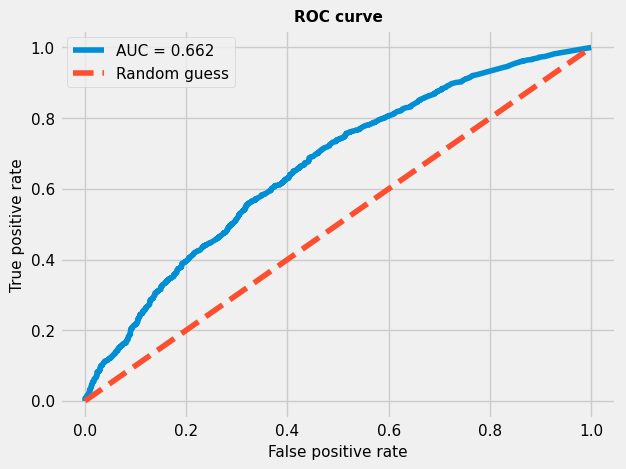

In [361]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('LGBMC optimisé sur le score métier')
#mlflow.sklearn.autolog() n'est pas supporté par la version sklearn que j'utilise ici
with mlflow.start_run(run_name='HyperOpt_lgbmClassifier') as run:
          
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.metrics import precision_score, recall_score
    cv = StratifiedKFold(5)
    seed = 42
    
    # Définir l'espace des hyperparamètres à explorer
    

    # Définir la fonction objectif à minimiser
   #Parameter space
    space_1 = {
        'num_boost_round': hp.quniform('num_boost_round', 50, 200, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
        'max_depth': hp.quniform('max_depth', 3, 7, 1),
        'num_leaves': hp.quniform('num_leaves', 10, 100, 10),
        'subsample': hp.uniform('subsample', 0.60, 0.95),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
        'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

    def objective_1(params):
        #objective function to be minimized. 
        #Hyperopt will seek to minimize the loss returned by this function.

        params = {
            'num_boost_round': int(params['num_boost_round']),
            'n_estimators': int(params['n_estimators']),
            'learning_rate': params['learning_rate'],
            'max_depth': int(params['max_depth']),
            'num_leaves': int(params['num_leaves']),
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'reg_lambda': params['reg_lambda'],
            
            }

    
        clf= LGBMClassifier(**params)
        cv = StratifiedKFold(5)
      
        score = cross_val_score(clf, X_train_selected, y_train_selected, scoring=credit_score_2, cv=cv).mean()

       
        return {'loss': -score, 'params': params, 'status': STATUS_OK} 



       # Créer une instance de Trials pour enregistrer les résultats de chaque essai
    trials = Trials()

    # Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
    best_1 = fmin(fn=objective_1, space=space_1, algo=tpe.suggest, max_evals=30,  # Nombre d'essais d'hyperparamètres à effectuer
        trials=trials
    )

        
    clf = LGBMClassifier( #Fit a new model based on the best parameters
        num_boost_round = int(best_1['num_boost_round']),
        n_estimators= int(best_1['n_estimators']), 
        seed = 2023,
        boosting_type = 'gbdt',
        objective = 'binary',
        colsample_bytree= best_1['colsample_bytree'],
        learning_rate= best_1['learning_rate'],
        max_depth= int(best_1['max_depth']),
        num_leaves = int(best_1['num_leaves']),
        subsample= best_1['subsample'],
        reg_lambda= best_1['reg_lambda'])
    
    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train_selected, y_train_selected)      
    
    y_pred_prob = clf.predict_proba(X_test_selected)[:, 1]

    plot_file = "roc-auc-plot.png"
    fpr, tpr, thresholds = roc_curve(y_test_selected, y_pred_prob)
    plt_roc, fig_roc, ax_roc = create_roc_plot(fpr, tpr,clf)
    fig_roc.savefig(plot_file)

    
    (auc_score, score, f1score) = eval_metrics(y_test_selected, y_pred_prob, seuil = optimal_threshold)

    pred = np.where(y_pred_prob > seuil, 1, 0)

    class_names = ["Non Solvable", "Solvable"]
    cf_matrix = metrics.confusion_matrix(y_test_selected, pred)
        

    ax, fig = plot_confusion_matrix(
    cf_matrix, class_names, normalize=False)
    plt.savefig("confusion_matrix.png")
    plt.close(fig)
    
    

#------------------------------------------------------------------------------------------   
    #mlflow.log_dict(best_1, "best_params.json")
    if not best_1 == None:
            for param in best_1:
                mlflow.log_param(param, best_1[param]) 
#--------------------------------------------------------------------------    
    mlflow.log_metric("metric_banking", score)
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("f1_score", f1score) 
    mlflow.log_metric("Precision", precision_score(y_test_selected, pred))
    mlflow.log_metric("Recall", recall_score(y_test_selected, pred))
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact(plot_file, "roc-auc-plots")
    mlflow.sklearn.log_model(clf, "best_lgbmc")
mlflow.end_run()

### Préparation du data set pour le dashboard:

In [362]:
path = "notebooks_P7/Data_projet7/new_data/"

import joblib
#final_model = joblib.load("final_model.joblib") # enregistrer dans le repertoire notbooks_P7

X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
X_train_selected = joblib.load("notebooks_P7/Data_projet7/new_data/X_train_selected.joblib")


y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
y_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_train_selected.joblib')

In [ ]:
final_model = best_lgbm_2 #joblib.load("final_model.joblib")

In [363]:
z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')
df_dash_ = pd.DataFrame(X_test_selected, columns= X_data.drop(['SK_ID_CURR', 'TARGET'], axis = 1).columns)

In [364]:
print(df_dash_.shape)
df_dash_.head()

(14559, 111)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,...,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_RECIVABLE_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0.686431,1.402025,-0.622162,0.974898,0.032323,1.796104,-1.150449,-1.763660,-0.638216,-0.474286,...,3.282687,-0.210408,-0.223746,2.782034,0.038463,-0.315184,0.082830,0.460705,-0.632668,-0.759620
1,0.686431,1.402025,-0.622162,0.018707,-0.400112,-1.024044,-0.289655,-1.375404,1.537187,-0.474286,...,-0.622870,4.085854,-0.223746,-0.629419,2.413324,9.164005,0.082830,0.460705,-0.159203,0.844844
2,0.686431,-0.713254,1.607299,0.018707,0.134993,-0.159896,1.411507,1.042533,0.352727,2.108432,...,1.219231,-0.273152,-0.223746,0.551469,-0.213177,-0.294120,-0.368893,0.460705,-1.023880,-0.582637
3,-1.456811,1.402025,1.607299,1.213946,-0.662484,0.106901,-0.340983,1.137864,1.403059,-0.474286,...,3.281171,0.046904,-0.223746,2.191590,0.180977,-0.062406,-0.368893,0.460705,0.400514,-0.416060
4,0.686431,-0.713254,1.607299,-0.698436,-0.846798,0.722068,0.798711,1.346725,0.364738,-0.474286,...,-0.622870,0.120186,0.792498,-0.629419,0.643437,0.295697,-0.368893,0.460705,-0.219643,-0.714391


In [365]:
dash = df_dash_.copy(deep = True)

In [366]:
dash["proba_1"] = final_model.predict_proba(df_dash_)[:, 1]
dash["prediction"] = final_model.predict(df_dash_)

In [368]:
SK_ID_CURR_selected["SK_ID_CURR"].values

array([207944, 452834, 202072, ..., 247740, 280520, 419590], dtype=int64)

In [369]:
dash["SK_ID_CURR"] = SK_ID_CURR_selected["SK_ID_CURR"].values

In [370]:
df_dash = dash.sort_values(by ="proba_1", ascending = False)

In [371]:
dash_final = df_dash.sample(5000)
dash_final.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,...,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,proba_1,prediction,SK_ID_CURR
6800,0.686431,-0.713254,-0.622162,-0.937484,0.819462,-0.776217,0.292239,-1.226052,-1.698558,2.108432,...,0.682678,-0.207802,-0.336249,0.082830,0.460705,-0.881216,2.981792,0.514576,1,425479
4212,0.686431,1.402025,-0.622162,-0.698436,0.240476,0.529778,0.932793,0.290864,-1.196080,2.108432,...,-0.366999,0.220169,-0.041341,-0.368893,0.460705,-1.015736,-0.635231,0.478123,0,165526
2068,0.686431,1.402025,-0.622162,-0.459388,-0.971409,1.796104,-0.647380,0.745274,0.630324,-0.474286,...,-0.629419,-0.414734,-0.336249,-0.368893,0.460705,0.619129,0.203869,0.533763,1,392969
2599,0.686431,1.402025,-0.622162,1.931089,-0.973917,-0.696806,1.588275,0.805650,0.535567,-0.474286,...,0.289049,0.051475,0.148243,0.082830,0.460705,2.470963,-1.003165,0.514555,1,153308
7978,0.686431,1.402025,1.607299,-0.698436,-1.283170,-0.193579,0.490743,-0.594558,1.950914,2.108432,...,-0.629419,1.631062,0.885513,-0.368893,0.460705,2.441357,-0.355057,0.519600,1,346393


In [376]:
# Fusionner les DataFrames en utilisant la colonne "Colonne_Y" comme clé de fusion
dash_final = pd.merge(dash_final, X_data[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [19]:
dash_final[dash_final["proba_1"]<optimal_threshold]

NameError: name 'dash_final' is not defined

In [25]:
dash_final.to_csv("df_dash.csv", index = False)

In [22]:
df_dash  = pd.read_csv('df_dash.csv')

In [24]:
.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,...,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,proba_1,prediction,SK_ID_CURR,TARGET
0,0.686431,-0.713254,-0.622162,-0.937484,0.819462,-0.776217,0.292239,-1.226052,-1.698558,2.108432,...,-0.207802,-0.336249,0.082830,0.460705,-0.881216,2.981792,0.514576,1,425479,1
1,0.686431,1.402025,-0.622162,-0.698436,0.240476,0.529778,0.932793,0.290864,-1.196080,2.108432,...,0.220169,-0.041341,-0.368893,0.460705,-1.015736,-0.635231,0.478123,0,165526,1
2,0.686431,1.402025,-0.622162,-0.459388,-0.971409,1.796104,-0.647380,0.745274,0.630324,-0.474286,...,-0.414734,-0.336249,-0.368893,0.460705,0.619129,0.203869,0.533763,1,392969,1
3,0.686431,1.402025,-0.622162,1.931089,-0.973917,-0.696806,1.588275,0.805650,0.535567,-0.474286,...,0.051475,0.148243,0.082830,0.460705,2.470963,-1.003165,0.514555,1,153308,1
4,0.686431,1.402025,1.607299,-0.698436,-1.283170,-0.193579,0.490743,-0.594558,1.950914,2.108432,...,1.631062,0.885513,-0.368893,0.460705,2.441357,-0.355057,0.519600,1,346393,1


### **Conclusion**

Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.62. Après rééquilibrage (SMOTE) des données la suite de l'étude a été déroulée vers 3 algorithmes plus complexes: le RandomForrest, le GradientBoostingClassifier et le LightGbmClassifier. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine  498 features, après RFECV 111 features. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC (0.76%), il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 5.76% (contre 7.79%), les FN sont à 11.45% (contre 0.42%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

##   ------------------------------------------------------------FIN-----------------------------------------------------------

### Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc.

In [ ]:


def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    
    mlflow.set_tracking_uri("http://127.0.0.1:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    mlflow.sklearn.autolog()
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        #mlflow.set_tag("tag1", "Random Forest")
        #mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [ ]:
from Fonctions_projet7 import hyper_parameter_tuning_rfc
experiment_name = "optimized model - RandomForrest"
run_name="Random_Search_CV_Tuned_Model"
model_tuned, best_params = hyper_parameter_tuning_rfc(X_train_scaled, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test_scaled) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test_scaled) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred_rfc, y_pred_prob)

In [ ]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

In [ ]:
#regeneration d'un fichier des dépendances
# executer cette commande dans anaconda prompt
#pip freeze > requirements.txt